# Introduction
In this notebook, we:
- Load a sample object detection dataset.
- Use two object detection models (YOLO and RetinaNet).
- Evaluate detection metrics (Precision, Recall, mAP, etc.).
- Build a graph from detection crops and run a GNN.
- Visualize key metrics and outcomes.



In [1]:
from ultralytics import YOLO
import torch
import torchvision
import pandas as pd
from torchvision.models.detection import retinanet_resnet50_fpn  # example backbone
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
from core.graph import Graph
from core.dataloader import GraphDataset, GraphDataLoader
import cv2
import random
import time
import torch.optim as optim
from models.cnn_gnn_model import CNN_GNN_Model
import os
from torchvision.datasets import VOCDetection
from PIL import Image
import albumentations as A
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
from PIL import Image
from sklearn.metrics import f1_score, balanced_accuracy_score
from torchvision.ops import box_iou
import math
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
import warnings
warnings.filterwarnings("ignore", message="A single label was found in 'y_true' and 'y_pred'")
warnings.filterwarnings("ignore", message="Using a target size .* that is different to the input size .*")
from torchvision.transforms import ToTensor
import gc
from tqdm import tqdm
from torchvision.datasets import VOCDetection
from tabulate import tabulate
import time
import matplotlib.patches as patches
from collections import Counter
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import itertools
from torch.utils.data import Subset
from models.pre_encoder import PreEncoder

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Device info
print("\nDevice Info:")
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available; using CPU.")


# Seed for NumPy
global_seed = 40
np.random.seed(global_seed)

# Seed for Python's random module
random.seed(global_seed)

# Seed for PyTorch (CPU)
torch.manual_seed(global_seed)


Device Info:
CUDA is available!
GPU: NVIDIA GeForce RTX 5080


In [2]:
##############################################
# --- Car Class Mapping Verification
##############################################

print("=== Car Class Matching Verification ===")
mapping_data = [
    ["VOC", "Label 'car' or 'vehicle' -> 1"],
    ["YOLOv11", "Class ID 2 -> label 1 via map_yolo_class"],
    ["RetinaNet", "Class ID 3 -> label 1 via map_retina_class"]
]
import pandas as pd
df = pd.DataFrame(mapping_data, columns=["Model/Dataset", "Car Label Mapping"])
print(tabulate(df, headers='keys', tablefmt='github', showindex=False))

##############################################
# --- Helper Functions (No Augmentation)
##############################################

def get_ground_truth_label(annotation):
    if 'labels' in annotation:
        # Since non-car images are filtered out, presence of any label means "car"
        return "car" if len(annotation['labels']) > 0 else "not car"
    else:
        return "not car"

def convert_voc_annotation(annotation):
    boxes = []
    labels = []
    objs = annotation.get('object', None)
    if objs is None:
        return {"bboxes": boxes, "labels": labels}
    if not isinstance(objs, list):
        objs = [objs]
    for obj in objs:
        name = obj.get('name', '').lower()
        # Only consider the object if it's a car or vehicle.
        if name in ["car", "vehicle"]:
            bbox = obj['bndbox']
            x1 = int(bbox['xmin'])
            y1 = int(bbox['ymin'])
            x2 = int(bbox['xmax'])
            y2 = int(bbox['ymax'])
            boxes.append([x1, y1, x2, y2])
            labels.append(1)  # Mark as car
    return {"bboxes": boxes, "labels": labels}

def extract_boxes(annotation):
    """
    Extract bounding boxes from an annotation.
    If the annotation is already in standardized format (with key "bboxes"), return that;
    otherwise, fall back to VOC extraction.
    """
    if "bboxes" in annotation:
        return annotation["bboxes"]
    else:
        objs = annotation.get('object', None)
        if objs is None:
            return []
        if not isinstance(objs, list):
            objs = [objs]
        boxes = []
        for obj in objs:
            bbox = obj['bndbox']
            x1 = int(bbox['xmin'])
            y1 = int(bbox['ymin'])
            x2 = int(bbox['xmax'])
            y2 = int(bbox['ymax'])
            boxes.append([x1, y1, x2, y2])
        return boxes

def compute_iou(boxA, boxB):
    # Compute IoU using torchvision's box_iou.
    tensorA = torch.tensor([boxA], dtype=torch.float32)
    tensorB = torch.tensor([boxB], dtype=torch.float32)
    return box_iou(tensorA, tensorB).item()

##############################################
# --- Filtered VOC Loader (No Augmentation)
##############################################

def load_filtered_voc_dataset(dataset, desired_count, car_proportion=1,
                              include_original=True, debug=False):
    """
    Iterates over the dataset until it collects at least desired_count valid images.
    Only images with at least one bounding box are collected, and if car_proportion==1,
    only images whose annotations indicate a car (label 1) are kept.
    """
    images_collected = []
    annotations_collected = []
    i = 0
    while len(images_collected) < desired_count and i < len(dataset):
        image, target = dataset[i]
        image_np = np.array(image)
        ann = convert_voc_annotation(target['annotation'])
        # Skip images without any bounding boxes.
        if len(ann["bboxes"]) == 0:
            i += 1
            continue
        # If we require only car images, check that at least one label equals 1.
        if car_proportion == 1 and 1 not in ann["labels"]:
            i += 1
            continue
        if include_original:
            images_collected.append(image_np)
            annotations_collected.append(ann)
        i += 1
    return images_collected, annotations_collected

##############################################
# --- Dataset Splitting and Filtering
##############################################
# Define total images to sample from and split ratios.
max_images = 5011  # Total images from the full dataset.
train_ratio = 0.70
val_ratio   = 0.25
test_ratio  = 0.5

desired_train = int(max_images * train_ratio)
desired_val   = int(max_images * val_ratio)
desired_test  = max_images - desired_train - desired_val  # or int(max_images * test_ratio)

# Load the full VOC dataset.
dataset = VOCDetection('./data', year='2007', image_set='trainval', download=True)

# Shuffle indices and select a subset.
all_indices = list(range(len(dataset)))
random.shuffle(all_indices)
selected_indices = all_indices[:max_images]

from torch.utils.data import Subset
train_dataset_full = Subset(dataset, selected_indices[:desired_train])
val_dataset_full   = Subset(dataset, selected_indices[desired_train:desired_train + desired_val])
test_dataset_full  = Subset(dataset, selected_indices[desired_train + desired_val:desired_train + desired_val + desired_test])

# Load filtered images (no augmentation applied) for each split.
train_images, train_annotations = load_filtered_voc_dataset(
    train_dataset_full,
    desired_count=desired_train,
    car_proportion=1,
    include_original=True,
    debug=False
)
val_images, val_annotations = load_filtered_voc_dataset(
    val_dataset_full,
    desired_count=desired_val,
    car_proportion=1,
    include_original=True,
    debug=False
)
test_images, test_annotations = load_filtered_voc_dataset(
    test_dataset_full,
    desired_count=desired_test,
    car_proportion=1,
    include_original=True,
    debug=False
)

# Print summary counts for each split.
final_car_count_train = sum(get_ground_truth_label(a) == 'car' for a in train_annotations)
total_train = len(train_images)
print("Training Data Summary:")
print(tabulate([
    ["Desired Images", desired_train],
    ["Filtered Images", total_train],
    ["Car Images", final_car_count_train]
], headers=["Category", "Count"], tablefmt="github"))

final_car_count_val = sum(get_ground_truth_label(a) == 'car' for a in val_annotations)
total_val = len(val_images)
print("\nValidation Data Summary:")
print(tabulate([
    ["Desired Images", desired_val],
    ["Filtered Images (original only)", total_val],
    ["Car Images", final_car_count_val]
], headers=["Category", "Count"], tablefmt="github"))

final_car_count_test = sum(get_ground_truth_label(a) == 'car' for a in test_annotations)
total_test = len(test_images)
print("\nTest Data Summary:")
print(tabulate([
    ["Desired Images", desired_test],
    ["Filtered Images (original only)", total_test],
    ["Car Images", final_car_count_test]
], headers=["Category", "Count"], tablefmt="github"))


=== Car Class Matching Verification ===
| Model/Dataset   | Car Label Mapping                          |
|-----------------|--------------------------------------------|
| VOC             | Label 'car' or 'vehicle' -> 1              |
| YOLOv11         | Class ID 2 -> label 1 via map_yolo_class   |
| RetinaNet       | Class ID 3 -> label 1 via map_retina_class |
Training Data Summary:
| Category        |   Count |
|-----------------|---------|
| Desired Images  |    3507 |
| Filtered Images |     527 |
| Car Images      |     527 |

Validation Data Summary:
| Category                        |   Count |
|---------------------------------|---------|
| Desired Images                  |    1252 |
| Filtered Images (original only) |     193 |
| Car Images                      |     193 |

Test Data Summary:
| Category                        |   Count |
|---------------------------------|---------|
| Desired Images                  |     252 |
| Filtered Images (original only) |      41 |
| 

In [3]:
# 3. Object Detection Models Setup
model_yolo = YOLO("yolo11x.pt")
model_yolo.eval()

retina_weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
model_retina = retinanet_resnet50_fpn(weights=retina_weights)
model_retina.eval()

# Move models to the appropriate device
model_yolo = model_yolo.to(device)
model_retina = model_retina.to(device)

# optional preprocessing transform (used during model training)
retina_preprocess = retina_weights.transforms()


# 4. Model Inference
For each image, run both models to get predicted bounding boxes.
(In a full implementation, you would run detection on GPU and properly preprocess images.)

In [4]:
def map_yolo_class(raw_class):
    return 1 if raw_class == 2 else 0


def run_yolo_inference(model, image):
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    results = model(image, augment=False, verbose=False)
    boxes = []
    for result in results:
        if hasattr(result, 'boxes'):
            for box in result.boxes:
                raw_class = int(box.cls.cpu().numpy()[0]) if hasattr(box, "cls") else None
                if raw_class == 2:  # Class 2 is 'car' in COCO
                    xyxy = box.xyxy.cpu().numpy().tolist()[0]
                    boxes.append(xyxy)
    return boxes

# --- RetinaNet Inference (requires PIL format) ---
def map_retina_class(raw_class):
    return 1 if raw_class == 3 else 0





def run_retina_inference(model, image):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    # Convert image to tensor and move to device
    image_tensor = ToTensor()(image).to(device)
    outputs = model([image_tensor])
    boxes = []
    for score, box, raw_class in zip(outputs[0]['scores'].detach().cpu().numpy(),
                                     outputs[0]['boxes'].detach().cpu().numpy(),
                                     outputs[0]['labels'].detach().cpu().numpy()):
        if score > 0.25 and raw_class == 3:  # assuming class 3 corresponds to 'car'
            boxes.append(box.tolist())
    return boxes





# Run inference on the first image as an example
sample_img = train_images[1]
yolo_boxes = run_yolo_inference(model_yolo, sample_img)
retina_boxes = run_retina_inference(model_retina, sample_img)

print("YOLOv11 boxes:", yolo_boxes)
print("RetinaNet boxes:", retina_boxes)

YOLOv11 boxes: [[0.13605356216430664, 0.46483278274536133, 183.20355224609375, 59.32654571533203]]
RetinaNet boxes: []


IoU YOLOv11 (train): 0.9783
IoU RetinaNet (train): 0.9469

📊 Training Set Evaluation Metrics Table:

| Model     |   Average IoU |   Detection Accuracy |   Avg Inference Time (s) |
|:----------|--------------:|---------------------:|-------------------------:|
| YOLOv11   |      0.802337 |                 0.85 |                0.014817  |
| RetinaNet |      0.554989 |                 1    |                0.0290041 |


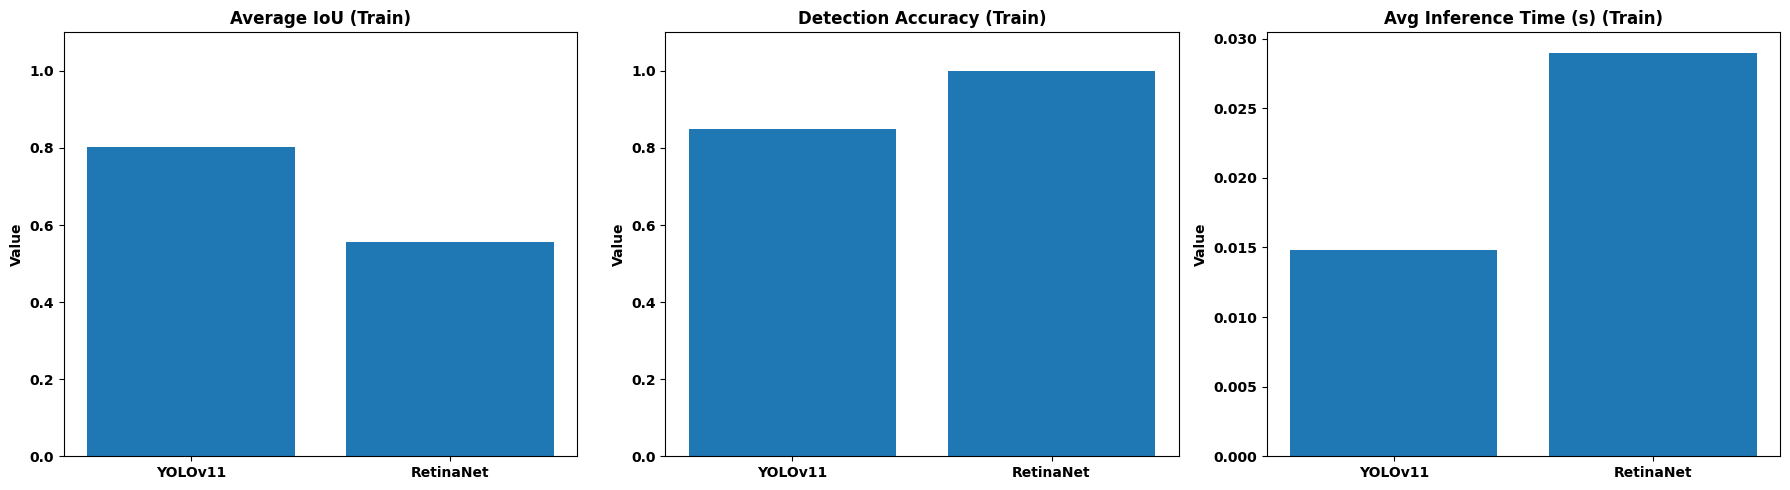

In [5]:
# %% [markdown]
# # 5. Evaluation Metrics Computation (Training Set)

def evaluate_detector_iou(detector_model, images, annotations, indices, iou_threshold=0.5):
    total_gt = 0
    matched_gt = 0
    for idx in indices:
        # Skip indices out of range
        if idx >= len(annotations):
            continue
        gt_boxes = extract_boxes(annotations[idx])
        if not gt_boxes:
            continue
        total_gt += len(gt_boxes)
        if detector_model == "yolo":
            pred_boxes = run_yolo_inference(model_yolo, images[idx])
        elif detector_model == "retina":
            pred_boxes = run_retina_inference(model_retina, images[idx])
        else:
            pred_boxes = []
        # Use the predicted box directly (no extra [0])
        for gt_box in gt_boxes:
            if any(compute_iou(gt_box, pb) >= iou_threshold for pb in pred_boxes):
                matched_gt += 1
    return matched_gt / total_gt if total_gt > 0 else 0.0

# --------------------------
# Example: Compare the first ground truth box with YOLO and Retina detections on the training set.
gt_boxes = extract_boxes(train_annotations[0])
if gt_boxes:
    gt_box = gt_boxes[0]
    # Here, yolo_boxes and retina_boxes should be computed on train_images[0]
    yolo_boxes = run_yolo_inference(model_yolo, train_images[0])
    retina_boxes = run_retina_inference(model_retina, train_images[0])
    iou_yolo = compute_iou(gt_box, yolo_boxes[0]) if yolo_boxes else 0.0
    iou_retina = compute_iou(gt_box, retina_boxes[0]) if retina_boxes else 0.0
    print(f"IoU YOLOv11 (train): {iou_yolo:.4f}")
    print(f"IoU RetinaNet (train): {iou_retina:.4f}")
else:
    print("DEBUG: No ground truth boxes available for the first training image.")
    iou_yolo = 0.0
    iou_retina = 0.0

# --------------------------
# Compute evaluation metrics on a random subset of training indices.
train_indices = list(range(len(train_images)))
num_train_samples = 10
sample_train_indices = random.sample(train_indices, min(num_train_samples, len(train_indices)))

iou_yolo_total = 0.0
iou_retina_total = 0.0
count_yolo = 0
count_retina = 0

for idx in sample_train_indices:
    gt_boxes = extract_boxes(train_annotations[idx])
    if not gt_boxes:
        continue
    gt_box = gt_boxes[0]  # only first GT box
    yolo_preds = run_yolo_inference(model_yolo, train_images[idx])
    retina_preds = run_retina_inference(model_retina, train_images[idx])
    if yolo_preds:
        iou_yolo_total += compute_iou(gt_box, yolo_preds[0])
        count_yolo += 1
    if retina_preds:
        iou_retina_total += compute_iou(gt_box, retina_preds[0])
        count_retina += 1

avg_iou_yolo = iou_yolo_total / count_yolo if count_yolo > 0 else 0.0
avg_iou_retina = iou_retina_total / count_retina if count_retina > 0 else 0.0

# Use the evaluation function for detection accuracy on the training set.
detector_acc_yolo = evaluate_detector_iou("yolo", train_images, train_annotations, sample_train_indices, iou_threshold=0.5)
detector_acc_retina = evaluate_detector_iou("retina", train_images, train_annotations, sample_train_indices, iou_threshold=0.5)

# Optionally, measure average inference time over these samples.
time_yolo = []
time_retina = []
for idx in sample_train_indices:
    start = time.time()
    _ = run_yolo_inference(model_yolo, train_images[idx])
    time_yolo.append(time.time() - start)
    start = time.time()
    _ = run_retina_inference(model_retina, train_images[idx])
    time_retina.append(time.time() - start)
avg_time_yolo = sum(time_yolo) / len(time_yolo) if time_yolo else 0.0
avg_time_retina = sum(time_retina) / len(time_retina) if time_retina else 0.0

# Build the metrics dataframe with computed values.
metrics_df = pd.DataFrame({
    "Model": ["YOLOv11", "RetinaNet"],
    "Average IoU": [avg_iou_yolo, avg_iou_retina],
    "Detection Accuracy": [detector_acc_yolo, detector_acc_retina],
    "Avg Inference Time (s)": [avg_time_yolo, avg_time_retina]
})

# --------------------------
# Print the evaluation metrics table.
try:
    print("\n📊 Training Set Evaluation Metrics Table:\n")
    print(metrics_df.to_markdown(index=False))
except ImportError:
    print("⚠ 'tabulate' is not installed. Showing plain table:")
    print(metrics_df)

# Extract valid metric values for plotting.
models_list = metrics_df["Model"]
avg_iou_vals = metrics_df["Average IoU"]
detection_accuracy_vals = metrics_df["Detection Accuracy"]
inference_time_vals = metrics_df["Avg Inference Time (s)"]

# Plot available metrics.
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(models_list, avg_iou_vals)
axs[0].set_title("Average IoU (Train)")

axs[1].bar(models_list, detection_accuracy_vals)
axs[1].set_title("Detection Accuracy (Train)")

axs[2].bar(models_list, inference_time_vals)
axs[2].set_title("Avg Inference Time (s) (Train)")

for ax in axs:
    ax.set_ylabel("Value")
    if ax != axs[2]:  # don't limit inference time
        ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()


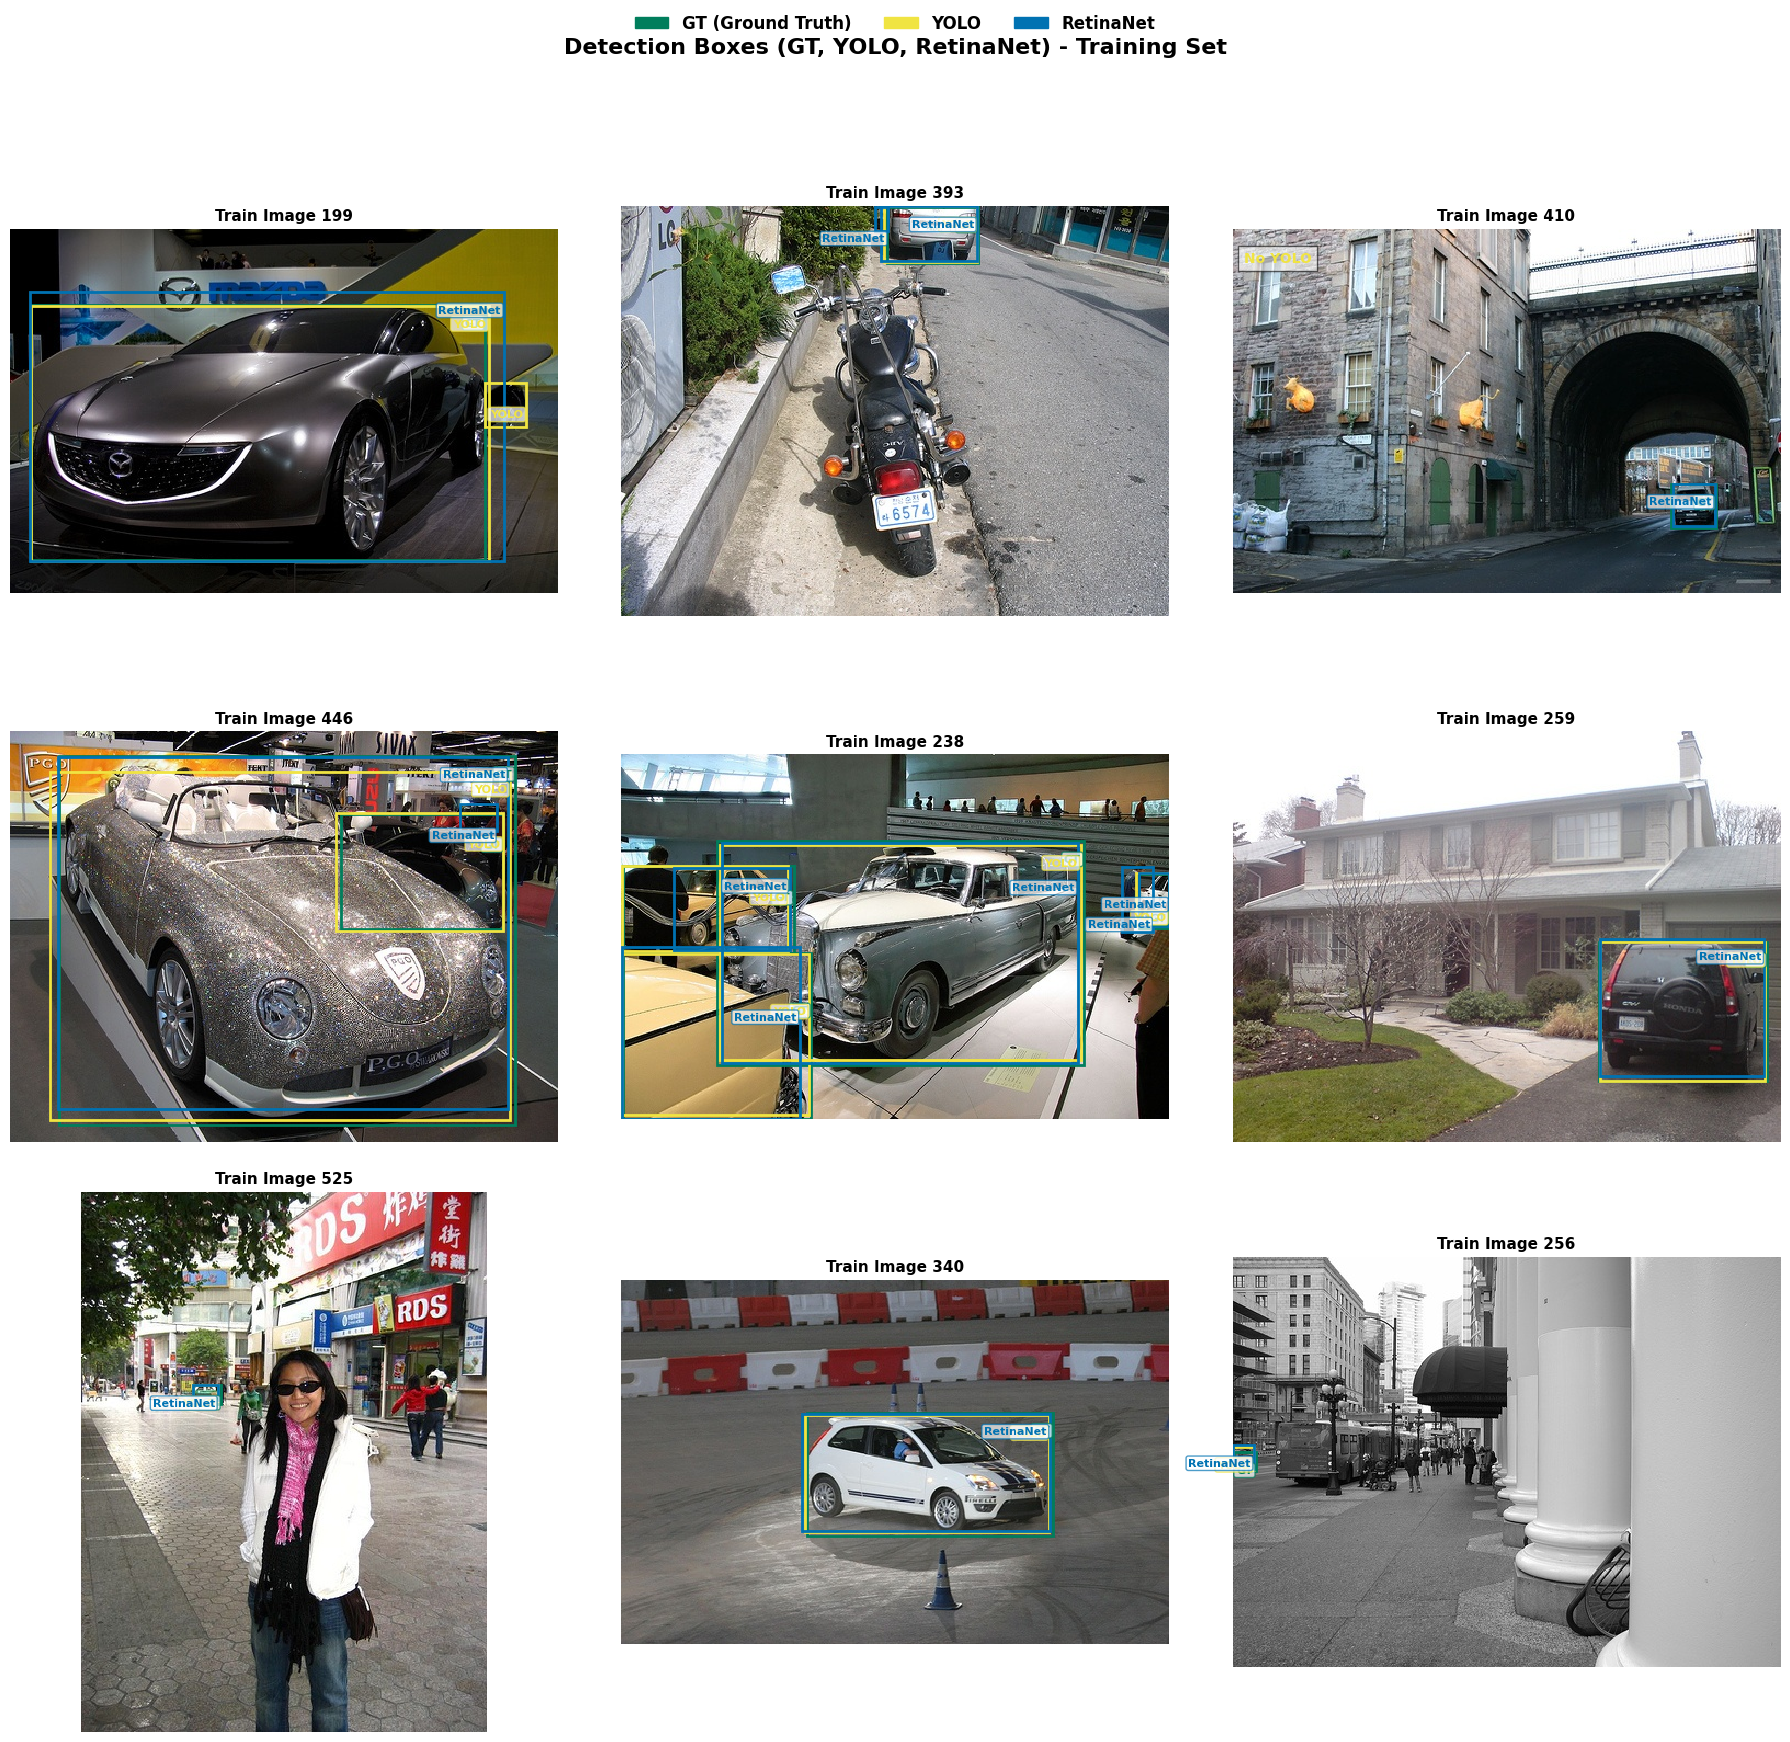


### 📊 Detection Summary Table (Training Set):

|   Image |   GT Boxes |   YOLO Boxes |   Retina Boxes |
|---------|------------|--------------|----------------|
|     199 |          1 |            2 |              1 |
|     393 |          1 |            1 |              2 |
|     410 |          1 |            0 |              1 |
|     446 |          2 |            2 |              2 |
|     238 |          4 |            4 |              5 |
|     259 |          1 |            1 |              1 |
|     525 |          1 |            1 |              1 |
|     340 |          1 |            1 |              1 |
|     256 |          1 |            1 |              1 |


In [6]:
# === Colorblind-Friendly Palette ===
colors = {
    'GT': '#007E5C',
    'YOLO': '#F0E442',
    'RetinaNet': '#0072B2'
}

# Number of test images to visualize (3x3)
num_test_images = 9
test_indices = random.sample(range(len(train_images)), min(num_test_images, len(train_images)))

# Summary data
summary_data = []

# === Setup plot grid (3x3) ===
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle("Detection Boxes (GT, YOLO, RetinaNet) - Training Set", fontsize=16)
axes = axes.flatten()

# === Legend (clean and separate) ===
legend_patches = [
    patches.Patch(color=colors['GT'], label='GT (Ground Truth)'),
    patches.Patch(color=colors['YOLO'], label='YOLO'),
    patches.Patch(color=colors['RetinaNet'], label='RetinaNet')
]
fig.legend(handles=legend_patches, loc='upper center', ncol=3, fontsize=12, frameon=False)

# === Function to add boxes with clean label placement ===
def add_boxes(ax, boxes, color, label, position='right', y_offset=0):
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1

        # Draw the rectangle
        rect = patches.Rectangle(
            (x1, y1),
            w,
            h,
            linewidth=2,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)

        # If you want the text “right-stuck” to the bounding box:
        lx = x2  # Right edge
        ly = y1  # Top edge
        ha = 'right'
        va = 'top'

        # Optional offset for each subsequent box
        offset = y_offset + (i * 12)

        ax.text(
            lx - 3,              # small horizontal inset
            ly + 12 + offset,    # small vertical inset
            label,
            color=color,
            fontsize=8,
            ha=ha,
            va=va,
            bbox=dict(
                facecolor='white',
                edgecolor=color,
                alpha=0.7,
                boxstyle='round,pad=0.2'
            )
        )

# === Draw detection boxes and labels for selected training images ===
for idx, ax in zip(test_indices, axes):
    image_np = train_images[idx]        # Use training images
    annotation = train_annotations[idx] # Use training annotations

    yolo_boxes = run_yolo_inference(model_yolo, image_np)
    retina_boxes = run_retina_inference(model_retina, image_np)
    gt_boxes = extract_boxes(annotation)

    ax.imshow(image_np, interpolation='none')
    ax.set_title(f"Train Image {idx}", fontsize=11)

    # Boxes with spaced labels
    if gt_boxes:
        add_boxes(ax, gt_boxes, colors['GT'], 'GT', position='center')
    else:
        ax.text(10, 10, 'No GT', color=colors['GT'], fontsize=10,
                bbox=dict(facecolor='white', alpha=0.6))

    if yolo_boxes:
        add_boxes(ax, yolo_boxes, colors['YOLO'], 'YOLO', position='left')
    else:
        ax.text(10, 30, 'No YOLO', color=colors['YOLO'], fontsize=10,
                bbox=dict(facecolor='white', alpha=0.6))

    if retina_boxes:
        add_boxes(ax, retina_boxes, colors['RetinaNet'], 'RetinaNet', position='right')
    else:
        ax.text(10, 50, 'No Retina', color=colors['RetinaNet'], fontsize=10,
                bbox=dict(facecolor='white', alpha=0.6))
    summary_data.append({
        'Image': idx,
        'GT Boxes': len(gt_boxes),
        'YOLO Boxes': len(yolo_boxes),
        'Retina Boxes': len(retina_boxes),
    })

    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for legend and title
plt.show()

# === Summary Table ===
summary_df = pd.DataFrame(summary_data)
print("\n### 📊 Detection Summary Table (Training Set):\n")
print(tabulate(summary_df, headers='keys', tablefmt='github', showindex=False))


✅ Found detections in image index: 0

===== Bounding Box Info =====
🔴 YOLO Box: [4.575061798095703, 12.857508659362793, 492.43182373046875, 254.774658203125]
YOLO Class: person
🔵 RetinaNet Box: [12.28244400024414, 14.386738777160645, 490.3717956542969, 251.66452026367188]
RetinaNet Class: Not available
🟣 Union Box: [4.575061798095703, 12.857508659362793, 492.43182373046875, 254.774658203125]
Crop Shapes:
  YOLO Crop: (242, 488, 3)
  Retina Crop: (237, 478, 3)
  Union Crop: (242, 488, 3)


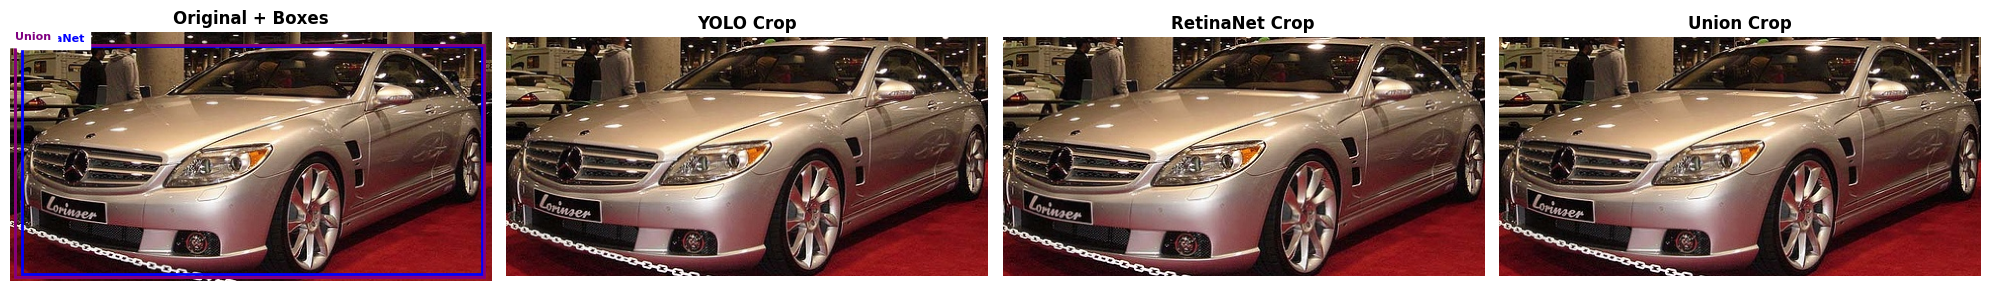

In [7]:
def crop_box(image, box):
    x1, y1, x2, y2 = map(int, box)
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2 = min(x2, image.shape[1])
    y2 = min(y2, image.shape[0])
    return image[y1:y2, x1:x2]

def visualize_and_crop(image_np, yolo_boxes, retina_boxes):
    if not yolo_boxes or not retina_boxes:
        print("❌ Missing boxes for this image.")
        return

    # Use first detected box from each
    yolo_box_coords = yolo_boxes[0]
    retina_box_coords = retina_boxes[0]

    print("\n===== Bounding Box Info =====")
    print(f"🔴 YOLO Box: {yolo_box_coords}")
    if hasattr(model_yolo, 'names'):
        print(f"YOLO Class: {model_yolo.names[0]}")  # Adjust if multiple classes

    print(f"🔵 RetinaNet Box: {retina_box_coords}")
    print("RetinaNet Class: Not available")

    # Compute union bounding box
    union_box = [
        min(yolo_box_coords[0], retina_box_coords[0]),
        min(yolo_box_coords[1], retina_box_coords[1]),
        max(yolo_box_coords[2], retina_box_coords[2]),
        max(yolo_box_coords[3], retina_box_coords[3])
    ]
    print(f"🟣 Union Box: {union_box}")

    # Crop regions
    crop_yolo = crop_box(image_np, yolo_box_coords)
    crop_retina = crop_box(image_np, retina_box_coords)
    crop_union = crop_box(image_np, union_box)

    print("Crop Shapes:")
    print(f"  YOLO Crop: {crop_yolo.shape}")
    print(f"  Retina Crop: {crop_retina.shape}")
    print(f"  Union Crop: {crop_union.shape}")

    # Visualization
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Original image with boxes
    axs[0].imshow(image_np)
    axs[0].set_title("Original + Boxes")

    def draw_box(ax, box, color, label):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, label, color=color, fontsize=8, backgroundcolor='white')

    draw_box(axs[0], yolo_box_coords, 'red', 'YOLO')
    draw_box(axs[0], retina_box_coords, 'blue', 'RetinaNet')
    draw_box(axs[0], union_box, 'purple', 'Union')

    # Show crops
    axs[1].imshow(crop_yolo)
    axs[1].set_title("YOLO Crop")

    axs[2].imshow(crop_retina)
    axs[2].set_title("RetinaNet Crop")

    axs[3].imshow(crop_union)
    axs[3].set_title("Union Crop")

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Try to find an image where both YOLO and RetinaNet return at least one box
for idx in range(len(train_images)):
    yolo_boxes = run_yolo_inference(model_yolo, train_images[idx])
    retina_boxes = run_retina_inference(model_retina, train_images[idx])

    if yolo_boxes and retina_boxes:
        print(f"✅ Found detections in image index: {idx}")
        visualize_and_crop(train_images[idx], yolo_boxes, retina_boxes)
        break
else:
    print("❌ No image found with both YOLO and RetinaNet detections.")



In [8]:
import torch
import torch.nn.functional as F
from collections import defaultdict
import numpy as np
import gc
from tqdm import tqdm
from torchvision.transforms import ToTensor
from PIL import Image

# --- NEW build_detection_graph function ---
def build_detection_graph(crops, label, gt_box, yolo_box=None, retina_box=None, union_box=None,
                          device=torch.device("cpu"), sources=None):
    """
    Build a detection graph for a single ground truth object using its associated detection crops.
    This version now supports multi–node graphs:
      - When both detectors fire, a 3–node graph is built (nodes: YOLO, Retina, Union)
      - When only one detector fires, a 2–node graph is built (nodes: Detector, Union)
    Pre–calculated performance metrics (IoU) are computed based on the GT.

    Args:
      crops (list): List of crop images (numpy arrays). For multi–node graphs, this contains 2 or 3 crops.
      label (int): Target label indicating the best branch:
                   0 → Not Car,
                   1 → YOLO is better,
                   2 → Retina is better,
                   3 → Union is best.
      gt_box (list): Ground truth bounding box [x1, y1, x2, y2].
      yolo_box (list, optional): YOLO detection bounding box.
      retina_box (list, optional): RetinaNet detection bounding box.
      union_box (list, optional): Union detection bounding box.
      device (torch.device): Device for tensor computations.
      sources (list, optional): List of branch identifiers for each crop (e.g., ["yolo", "retina", "union"]).

    Returns:
      Graph: A graph object with node features, edge indices (constructed as described), and attached attributes:
             - gt_box, yolo_box, retina_box, union_box.
             - Pre–calculated IoU for each branch.
             - The target label (graph.label) and a dictionary of pre–calculated metrics.
             - The branch source(s) used.
    """
    # Build node features: convert each crop to a tensor and resize to 128x128.
    node_features_list = []
    for crop in crops:
        crop_tensor = torch.from_numpy(crop).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0
        resized = F.interpolate(crop_tensor, size=(128, 128), mode='bilinear', align_corners=False)
        node_features_list.append(resized.squeeze(0))
    node_features = torch.stack(node_features_list)

    n_nodes = node_features.shape[0]

    # Build edge indices based on the sources of each node.
    edge_indices = []
    if sources is not None and len(sources) == n_nodes:
        # Identify indices for union and detector nodes (YOLO/Retina)
        union_indices = [i for i, s in enumerate(sources) if s == "union"]
        detector_indices = [i for i, s in enumerate(sources) if s in ["yolo", "retina"]]

        # Create edges from each detector node to every union node.
        for d_idx in detector_indices:
            for u_idx in union_indices:
                edge_indices.append([d_idx, u_idx])
    else:
        # Fallback: fully connect nodes if sources aren't properly specified.
        for i in range(n_nodes):
            for j in range(n_nodes):
                if i != j:
                    edge_indices.append([i, j])

    if edge_indices:
        edge_index = torch.tensor(edge_indices, dtype=torch.long, device=device).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long, device=device)

    # Optionally build edge features based on source flags.
    source_mapping = {"yolo": 0, "retina": 1, "union": 2, "none": -1}
    if sources is not None and len(sources) == n_nodes:
        node_sources = torch.tensor([source_mapping.get(s, -1) for s in sources],
                                      dtype=torch.long, device=device)
        if edge_index.numel() > 0:
            src_indices = edge_index[0]
            edge_features = node_sources[src_indices].float().unsqueeze(1)
        else:
            edge_features = None
    else:
        edge_features = None

    # Create the graph object.
    graph = Graph(node_features, edge_index, edge_features=edge_features)

    # Save the bounding boxes.
    graph.gt_box = gt_box
    graph.yolo_box = yolo_box
    graph.retina_box = retina_box
    graph.union_box = union_box

    # Pre–calculate IoU values for each branch (if available).
    graph.precalc_yolo_iou = torch.tensor(compute_iou(gt_box, yolo_box)) if yolo_box is not None else torch.tensor(0.0, device=device)
    graph.precalc_retina_iou = torch.tensor(compute_iou(gt_box, retina_box)) if retina_box is not None else torch.tensor(0.0, device=device)
    graph.precalc_union_iou = torch.tensor(compute_iou(gt_box, union_box)) if union_box is not None else torch.tensor(0.0, device=device)

    # Save the target label.
    graph.label = torch.tensor(label, dtype=torch.long, device=device)

    # Store a dictionary of pre–calculated metrics.
    graph.precalc_metrics = {
        "yolo_iou": graph.precalc_yolo_iou.item(),
        "retina_iou": graph.precalc_retina_iou.item(),
        "union_iou": graph.precalc_union_iou.item()
    }

    # Save branch source information.
    graph.sources = sources

    return graph

# ---------------------------
# Process training images in batches and group graphs per image.
graphs_per_image_train = defaultdict(list)
batch_size = 16
model_retina = model_retina.to(device)

for batch_start in tqdm(range(0, len(train_images), batch_size), desc="Processing Training Images in Batches"):
    batch_indices = list(range(batch_start, min(batch_start + batch_size, len(train_images))))
    batch_images = [train_images[i] for i in batch_indices]

    # --- Run YOLO in batch ---
    yolo_batch_results = model_yolo(batch_images, augment=False, verbose=False)
    yolo_batch_detections = []
    for result in yolo_batch_results:
        boxes = []
        if hasattr(result, 'boxes'):
            for box in result.boxes:
                raw_class = int(box.cls.cpu().numpy()[0]) if hasattr(box, "cls") else None
                # Updated mapping: class ID 2 means "car"
                if raw_class == 2:
                    xyxy = box.xyxy.cpu().numpy().tolist()[0]
                    boxes.append(xyxy)
        yolo_batch_detections.append(boxes)

    # --- Run RetinaNet in batch ---
    pil_images = [Image.fromarray(img) if isinstance(img, np.ndarray) else img for img in batch_images]
    retina_tensors = [ToTensor()(img).to(device) for img in pil_images]
    with torch.no_grad():
        retina_outputs = model_retina(retina_tensors)
    retina_batch_detections = []
    for output in retina_outputs:
        boxes = []
        for score, box, raw_class in zip(output['scores'].detach().cpu().numpy(),
                                         output['boxes'].detach().cpu().numpy(),
                                         output['labels'].detach().cpu().numpy()):
            # Updated mapping: class ID 3 means "car"
            if score > 0.25 and raw_class == 3:
                boxes.append(box.tolist())
        retina_batch_detections.append(boxes)

    # Process each image in the current batch.
    for local_idx, idx in enumerate(batch_indices):
        image_np = np.array(train_images[idx])
        gt_boxes = extract_boxes(train_annotations[idx])
        if not gt_boxes:
            continue

        yolo_dets = yolo_batch_detections[local_idx]
        retina_dets = retina_batch_detections[local_idx]

        for gt_box in gt_boxes:
            # Find the best YOLO detection.
            best_yolo = None
            best_yolo_iou = 0.0
            for det in yolo_dets:
                iou_val = compute_iou(gt_box, det)
                if iou_val > best_yolo_iou:
                    best_yolo_iou = iou_val
                    best_yolo = det

            # Find the best RetinaNet detection.
            best_retina = None
            best_retina_iou = 0.0
            for det in retina_dets:
                iou_val = compute_iou(gt_box, det)
                if iou_val > best_retina_iou:
                    best_retina_iou = iou_val
                    best_retina = det

            # Decide which branch to use and build the graph accordingly.
            if best_yolo is not None and best_retina is not None:
                # Both detectors fired: compute the union box.
                union_box = [
                    min(best_yolo[0], best_retina[0]),
                    min(best_yolo[1], best_retina[1]),
                    max(best_yolo[2], best_retina[2]),
                    max(best_yolo[3], best_retina[3])
                ]
                crop_yolo = crop_box(image_np, best_yolo)
                crop_retina = crop_box(image_np, best_retina)
                crop_union = crop_box(image_np, union_box)
                # Create a 3-node graph: YOLO, Retina, and Union.
                target_class = 3  # Union is considered best by default.
                crops = [crop_yolo, crop_retina, crop_union]
                sources = ["yolo", "retina", "union"]
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                              yolo_box=best_yolo, retina_box=best_retina, union_box=union_box,
                                              device=device, sources=sources)
            elif best_yolo is not None:
                # Only YOLO detection is available: build a 2-node graph.
                crop_yolo = crop_box(image_np, best_yolo)
                target_class = 1
                # Use the same crop for both nodes (detector and union).
                crops = [crop_yolo, crop_yolo]
                sources = ["yolo", "union"]
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                              yolo_box=best_yolo, retina_box=None, union_box=best_yolo,
                                              device=device, sources=sources)
            elif best_retina is not None:
                # Only RetinaNet detection is available: build a 2-node graph.
                crop_retina = crop_box(image_np, best_retina)
                target_class = 2
                crops = [crop_retina, crop_retina]
                sources = ["retina", "union"]
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                              yolo_box=None, retina_box=best_retina, union_box=best_retina,
                                              device=device, sources=sources)
            else:
                # No detection: use a default crop and assign label 0 (not car).
                h, w, _ = image_np.shape
                x1, y1 = w // 4, h // 4
                x2, y2 = (3 * w) // 4, (3 * h) // 4
                default_crop = image_np[y1:y2, x1:x2]
                target_class = 0
                crops = [default_crop]
                sources = ["none"]
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                              yolo_box=None, retina_box=None, union_box=None,
                                              device=device, sources=sources)
            # Append the constructed graph to the image's group.
            graphs_per_image_train[idx].append(graph)

    # Free memory for this batch.
    del retina_outputs, retina_tensors, pil_images, batch_images
    gc.collect()
    torch.cuda.empty_cache()

# Flatten training groups into a global list.
all_graphs_train = []
graph_image_ids_train = []
for img_idx, graphs in graphs_per_image_train.items():
    for graph in graphs:
        graph.image_id = f"{img_idx}_{graph.gt_box}"
        all_graphs_train.append(graph)
        graph_image_ids_train.append(graph.image_id)

print(f"Built training graph dataset with {len(all_graphs_train)} samples.")
label_counts = defaultdict(int)
for g in all_graphs_train:
    label_counts[g.label.item()] += 1
print("Training Label Distribution:", dict(label_counts))

# ---------------------------
# Process validation images similarly.
graphs_per_image_val = defaultdict(list)

for batch_start in tqdm(range(0, len(val_images), batch_size), desc="Processing Validation Images in Batches"):
    batch_indices = list(range(batch_start, min(batch_start + batch_size, len(val_images))))
    batch_images = [val_images[i] for i in batch_indices]

    # Run YOLO on validation batch.
    yolo_batch_results = model_yolo(batch_images, augment=False, verbose=False)
    yolo_batch_detections = []
    for result in yolo_batch_results:
        boxes = []
        if hasattr(result, 'boxes'):
            for box in result.boxes:
                raw_class = int(box.cls.cpu().numpy()[0]) if hasattr(box, "cls") else None
                if raw_class == 2:
                    xyxy = box.xyxy.cpu().numpy().tolist()[0]
                    boxes.append(xyxy)
        yolo_batch_detections.append(boxes)

    # Run RetinaNet on validation batch.
    pil_images = [Image.fromarray(img) if isinstance(img, np.ndarray) else img for img in batch_images]
    retina_tensors = [ToTensor()(img).to(device) for img in pil_images]
    with torch.no_grad():
        retina_outputs = model_retina(retina_tensors)
    retina_batch_detections = []
    for output in retina_outputs:
        boxes = []
        for score, box, raw_class in zip(output['scores'].detach().cpu().numpy(),
                                         output['boxes'].detach().cpu().numpy(),
                                         output['labels'].detach().cpu().numpy()):
            if score > 0.25 and raw_class == 3:
                boxes.append(box.tolist())
        retina_batch_detections.append(boxes)

    # Process each validation image.
    for local_idx, idx in enumerate(batch_indices):
        image_np = np.array(val_images[idx])
        gt_boxes = extract_boxes(val_annotations[idx])
        if not gt_boxes:
            continue

        yolo_dets = yolo_batch_detections[local_idx]
        retina_dets = retina_batch_detections[local_idx]

        for gt_box in gt_boxes:
            best_yolo = None
            best_yolo_iou = 0.0
            for det in yolo_dets:
                iou_val = compute_iou(gt_box, det)
                if iou_val > best_yolo_iou:
                    best_yolo_iou = iou_val
                    best_yolo = det

            best_retina = None
            best_retina_iou = 0.0
            for det in retina_dets:
                iou_val = compute_iou(gt_box, det)
                if iou_val > best_retina_iou:
                    best_retina_iou = iou_val
                    best_retina = det

            if best_yolo is not None and best_retina is not None:
                union_box = [
                    min(best_yolo[0], best_retina[0]),
                    min(best_yolo[1], best_retina[1]),
                    max(best_yolo[2], best_retina[2]),
                    max(best_yolo[3], best_retina[3])
                ]
                crop_yolo = crop_box(image_np, best_yolo)
                crop_retina = crop_box(image_np, best_retina)
                crop_union = crop_box(image_np, union_box)
                # Create a 3-node graph.
                target_class = 3
                crops = [crop_yolo, crop_retina, crop_union]
                sources = ["yolo", "retina", "union"]
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                              yolo_box=best_yolo, retina_box=best_retina, union_box=union_box,
                                              device=device, sources=sources)
            elif best_yolo is not None:
                crop_yolo = crop_box(image_np, best_yolo)
                target_class = 1
                # Create a 2-node graph.
                crops = [crop_yolo, crop_yolo]
                sources = ["yolo", "union"]
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                              yolo_box=best_yolo, retina_box=None, union_box=best_yolo,
                                              device=device, sources=sources)
            elif best_retina is not None:
                crop_retina = crop_box(image_np, best_retina)
                target_class = 2
                crops = [crop_retina, crop_retina]
                sources = ["retina", "union"]
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                              yolo_box=None, retina_box=best_retina, union_box=best_retina,
                                              device=device, sources=sources)
            else:
                h, w, _ = image_np.shape
                x1, y1 = w // 4, h // 4
                x2, y2 = (3 * w) // 4, (3 * h) // 4
                default_crop = image_np[y1:y2, x1:x2]
                target_class = 0
                crops = [default_crop]
                sources = ["none"]
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                              yolo_box=None, retina_box=None, union_box=None,
                                              device=device, sources=sources)
            graphs_per_image_val[idx].append(graph)

    del retina_outputs, retina_tensors, pil_images, batch_images
    gc.collect()
    torch.cuda.empty_cache()

# Flatten validation groups.
all_graphs_val = []
graph_image_ids_val = []
for img_idx, graphs in graphs_per_image_val.items():
    for graph in graphs:
        graph.image_id = f"{img_idx}_{graph.gt_box}"
        all_graphs_val.append(graph)
        graph_image_ids_val.append(graph.image_id)

print(f"Built validation graph dataset with {len(all_graphs_val)} samples.")
val_label_counts = defaultdict(int)
for g in all_graphs_val:
    val_label_counts[g.label.item()] += 1
print("Validation Label Distribution:", dict(val_label_counts))

# ---------------------------
# Process test images similarly.
graphs_per_image_test = defaultdict(list)

for batch_start in tqdm(range(0, len(test_images), batch_size), desc="Processing Test Images in Batches"):
    batch_indices = list(range(batch_start, min(batch_start + batch_size, len(test_images))))
    batch_images = [test_images[i] for i in batch_indices]

    # --- Run YOLO on test batch ---
    yolo_batch_results = model_yolo(batch_images, augment=False, verbose=False)
    yolo_batch_detections = []
    for result in yolo_batch_results:
        boxes = []
        if hasattr(result, 'boxes'):
            for box in result.boxes:
                raw_class = int(box.cls.cpu().numpy()[0]) if hasattr(box, "cls") else None
                if raw_class == 2:
                    xyxy = box.xyxy.cpu().numpy().tolist()[0]
                    boxes.append(xyxy)
        yolo_batch_detections.append(boxes)

    # --- Run RetinaNet on test batch ---
    pil_images = [Image.fromarray(img) if isinstance(img, np.ndarray) else img for img in batch_images]
    retina_tensors = [ToTensor()(img).to(device) for img in pil_images]
    with torch.no_grad():
        retina_outputs = model_retina(retina_tensors)
    retina_batch_detections = []
    for output in retina_outputs:
        boxes = []
        for score, box, raw_class in zip(output['scores'].detach().cpu().numpy(),
                                         output['boxes'].detach().cpu().numpy(),
                                         output['labels'].detach().cpu().numpy()):
            if score > 0.25 and raw_class == 3:
                boxes.append(box.tolist())
        retina_batch_detections.append(boxes)

    # Process each test image in the current batch.
    for local_idx, idx in enumerate(batch_indices):
        image_np = np.array(test_images[idx])
        gt_boxes = extract_boxes(test_annotations[idx])
        if not gt_boxes:
            continue

        yolo_dets = yolo_batch_detections[local_idx]
        retina_dets = retina_batch_detections[local_idx]

        for gt_box in gt_boxes:
            # Find best YOLO detection.
            best_yolo = None
            best_yolo_iou = 0.0
            for det in yolo_dets:
                iou_val = compute_iou(gt_box, det)
                if iou_val > best_yolo_iou:
                    best_yolo_iou = iou_val
                    best_yolo = det

            # Find best RetinaNet detection.
            best_retina = None
            best_retina_iou = 0.0
            for det in retina_dets:
                iou_val = compute_iou(gt_box, det)
                if iou_val > best_retina_iou:
                    best_retina_iou = iou_val
                    best_retina = det

            if best_yolo is not None and best_retina is not None:
                union_box = [
                    min(best_yolo[0], best_retina[0]),
                    min(best_yolo[1], best_retina[1]),
                    max(best_yolo[2], best_retina[2]),
                    max(best_yolo[3], best_retina[3])
                ]
                crop_yolo = crop_box(image_np, best_yolo)
                crop_retina = crop_box(image_np, best_retina)
                crop_union = crop_box(image_np, union_box)
                # Create a 3-node graph.
                target_class = 3
                crops = [crop_yolo, crop_retina, crop_union]
                sources = ["yolo", "retina", "union"]
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                              yolo_box=best_yolo, retina_box=best_retina, union_box=union_box,
                                              device=device, sources=sources)
            elif best_yolo is not None:
                crop_yolo = crop_box(image_np, best_yolo)
                target_class = 1
                crops = [crop_yolo, crop_yolo]
                sources = ["yolo", "union"]
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                              yolo_box=best_yolo, retina_box=None, union_box=best_yolo,
                                              device=device, sources=sources)
            elif best_retina is not None:
                crop_retina = crop_box(image_np, best_retina)
                target_class = 2
                crops = [crop_retina, crop_retina]
                sources = ["retina", "union"]
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                              yolo_box=None, retina_box=best_retina, union_box=best_retina,
                                              device=device, sources=sources)
            else:
                h, w, _ = image_np.shape
                x1, y1 = w // 4, h // 4
                x2, y2 = (3 * w) // 4, (3 * h) // 4
                default_crop = image_np[y1:y2, x1:x2]
                target_class = 0
                crops = [default_crop]
                sources = ["none"]
                graph = build_detection_graph(crops, label=target_class, gt_box=gt_box,
                                              yolo_box=None, retina_box=None, union_box=None,
                                              device=device, sources=sources)
            graphs_per_image_test[idx].append(graph)

    # Free memory for this batch.
    del retina_outputs, retina_tensors, pil_images, batch_images
    gc.collect()
    torch.cuda.empty_cache()

# Flatten test groups into a global list.
all_graphs_test = []
graph_image_ids_test = []
for img_idx, graphs in graphs_per_image_test.items():
    for graph in graphs:
        graph.image_id = f"{img_idx}_{graph.gt_box}"
        all_graphs_test.append(graph)
        graph_image_ids_test.append(graph.image_id)

print(f"Built test graph dataset with {len(all_graphs_test)} samples.")
test_label_counts = defaultdict(int)
for g in all_graphs_test:
    test_label_counts[g.label.item()] += 1
print("Test Label Distribution:", dict(test_label_counts))



Processing Training Images in Batches: 100%|██████████| 33/33 [00:37<00:00,  1.15s/it]


Built training graph dataset with 1156 samples.
Training Label Distribution: {3: 1024, 1: 16, 2: 91, 0: 25}


Processing Validation Images in Batches: 100%|██████████| 13/13 [00:12<00:00,  1.00it/s]


Built validation graph dataset with 398 samples.
Validation Label Distribution: {3: 355, 0: 8, 1: 4, 2: 31}


Processing Test Images in Batches: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

Built test graph dataset with 90 samples.
Test Label Distribution: {3: 81, 2: 5, 0: 4}


Training Graph constructed with node features shape: torch.Size([3, 3, 128, 128])
Training Edge index shape: torch.Size([2, 2])
Pre–calculated metrics: {'yolo_iou': 0.9769094586372375, 'retina_iou': 0.9222930669784546, 'union_iou': 0.9717618227005005}
Training Label Distribution:
  0 (not car): 25
  1 (YOLO better): 16
  2 (Retina better): 91
  3 (Union best): 1024
Validation Graph constructed with node features shape: torch.Size([3, 3, 128, 128])
Validation Edge index shape: torch.Size([2, 2])
Pre–calculated metrics: {'yolo_iou': 0.953515887260437, 'retina_iou': 0.9022336006164551, 'union_iou': 0.953515887260437}
Validation Label Distribution:
  0 (not car): 8
  1 (YOLO better): 4
  2 (Retina better): 31
  3 (Union best): 355
Test Graph constructed with node features shape: torch.Size([3, 3, 128, 128])
Test Edge index shape: torch.Size([2, 2])
Pre–calculated metrics: {'yolo_iou': 0.9407351613044739, 'retina_iou': 0.9033256769180298, 'union_iou': 0.9198882579803467}
Test Label Distribu

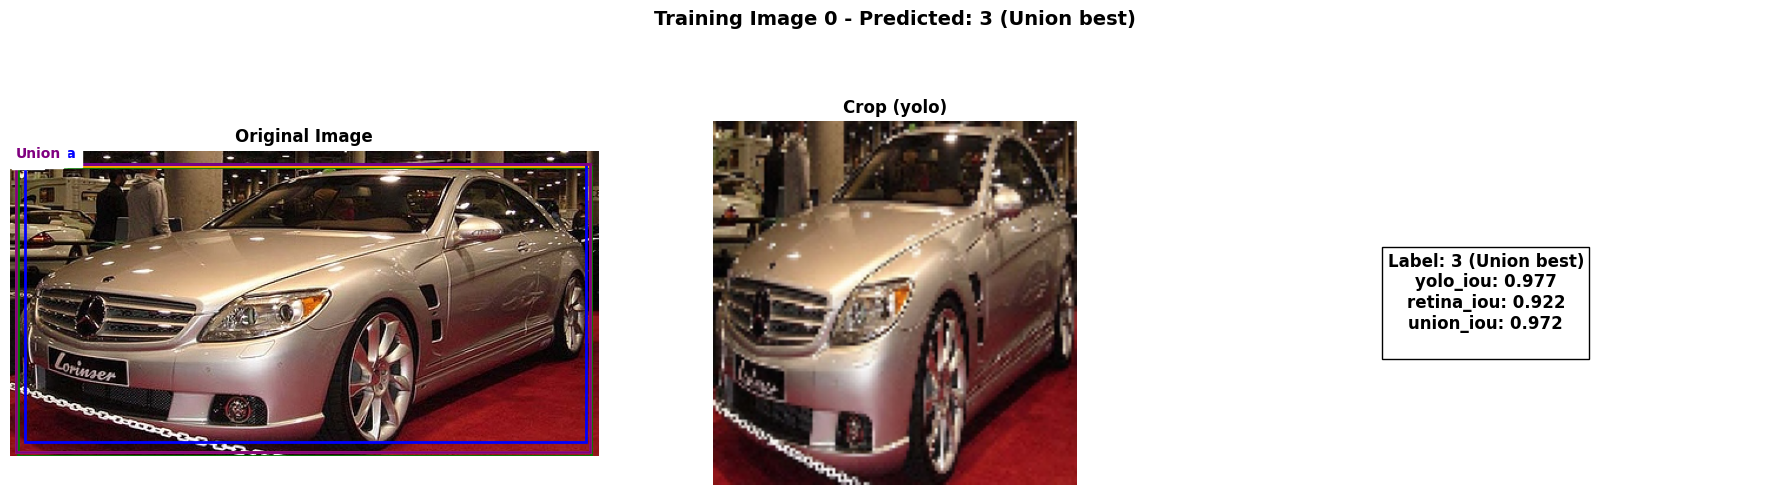

In [9]:
# Create training graph dataset & loader.
train_graph_dataset = GraphDataset(all_graphs_train)
train_graph_loader = GraphDataLoader(train_graph_dataset, batch_size=1, shuffle=True)
if len(all_graphs_train) > 0:
    detection_graph = all_graphs_train[0]
    print("Training Graph constructed with node features shape:", detection_graph.node_features.shape)
    print("Training Edge index shape:", detection_graph.edge_index.shape if detection_graph.edge_index is not None else "None")
    print("Pre–calculated metrics:", detection_graph.precalc_metrics)
else:
    print("No training graphs were built.")

# Label mapping: 0 = not car, 1 = YOLO better, 2 = Retina better, 3 = Union best.
label_mapping = {0: "not car", 1: "YOLO better", 2: "Retina better", 3: "Union best"}
train_labels = [g.label.item() for g in all_graphs_train]
print("Training Label Distribution:")
for key, text in sorted(label_mapping.items()):
    print(f"  {key} ({text}): {train_labels.count(key)}")

# Create validation graph dataset & loader.
val_graph_dataset = GraphDataset(all_graphs_val)
val_graph_loader = GraphDataLoader(val_graph_dataset, batch_size=1, shuffle=False)
if len(all_graphs_val) > 0:
    detection_graph = all_graphs_val[0]
    print("Validation Graph constructed with node features shape:", detection_graph.node_features.shape)
    print("Validation Edge index shape:", detection_graph.edge_index.shape if detection_graph.edge_index is not None else "None")
    print("Pre–calculated metrics:", detection_graph.precalc_metrics)
else:
    print("No validation graphs were built.")

val_labels = [g.label.item() for g in all_graphs_val]
print("Validation Label Distribution:")
for key, text in sorted(label_mapping.items()):
    print(f"  {key} ({text}): {val_labels.count(key)}")

# Create test graph dataset & loader.
test_graph_dataset = GraphDataset(all_graphs_test)
test_graph_loader = GraphDataLoader(test_graph_dataset, batch_size=1, shuffle=False)
if len(all_graphs_test) > 0:
    detection_graph = all_graphs_test[0]
    print("Test Graph constructed with node features shape:", detection_graph.node_features.shape)
    print("Test Edge index shape:", detection_graph.edge_index.shape if detection_graph.edge_index is not None else "None")
    print("Pre–calculated metrics:", detection_graph.precalc_metrics)
else:
    print("No test graphs were built.")

test_labels = [g.label.item() for g in all_graphs_test]
print("Test Label Distribution:")
for key, text in sorted(label_mapping.items()):
    print(f"  {key} ({text}): {test_labels.count(key)}")

def plot_detection_instance(graph, images, title_prefix=""):
    """
    Plot an instance displaying:
      1. The original image with drawn bounding boxes (GT, YOLO, Retina, Union)
      2. The winning branch's crop (single node) with its source identifier.
      3. The target label along with pre–calculated metrics.

    Args:
      graph: A detection graph with attributes:
             'gt_box', 'yolo_box', 'retina_box', 'union_box',
             'label', 'precalc_metrics', 'sources', and 'image_id' (format: "imgIdx_gtBox").
      images: List of original images (e.g., train_images).
      title_prefix: Optional prefix for the title.
    """
    # Extract image index from graph.image_id (assumed format "imgIdx_gtBox")
    img_idx = int(graph.image_id.split("_")[0])
    orig_img = np.array(images[img_idx])

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    title = f"{title_prefix} Image {img_idx} - Predicted: {graph.label.item()} ({label_mapping.get(graph.label.item(), 'unknown')})"
    fig.suptitle(title, fontsize=14)

    # --- Panel 1: Original image with bounding boxes ---
    axs[0].imshow(orig_img)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    def draw_box(ax, box, edgecolor, label):
        if box is not None:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor=edgecolor, facecolor="none")
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, label, color=edgecolor, fontsize=10, backgroundcolor="white")

    draw_box(axs[0], graph.gt_box, "green", "GT")
    draw_box(axs[0], graph.yolo_box, "orange", "YOLO")
    draw_box(axs[0], graph.retina_box, "blue", "Retina")
    draw_box(axs[0], graph.union_box, "purple", "Union")

    # --- Panel 2: Winning branch crop ---
    # (graph.node_features contains only one node)
    node_img = graph.node_features[0].detach().cpu().permute(1, 2, 0).numpy()
    axs[1].imshow(node_img)
    branch = graph.sources[0] if graph.sources is not None and len(graph.sources) > 0 else "N/A"
    axs[1].set_title(f"Crop ({branch})")
    axs[1].axis("off")

    # --- Panel 3: Label info and pre–calculated metrics ---
    metrics_text = f"Label: {graph.label.item()} ({label_mapping.get(graph.label.item(), 'unknown')})\n"
    for key, value in graph.precalc_metrics.items():
        metrics_text += f"{key}: {value:.3f}\n"
    axs[2].axis("off")
    axs[2].text(0.5, 0.5, metrics_text, ha="center", va="center", fontsize=12,
                bbox=dict(facecolor="white", edgecolor="black"))

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()


# Plot one instance from the training graph dataset.
if len(all_graphs_train) > 0:
    plot_detection_instance(all_graphs_train[0], train_images, title_prefix="Training")
else:
    print("No training graph instance to visualize.")


In [10]:
def report_graph_info(graph, title_prefix=""):
    n_nodes = graph.node_features.shape[0]
    print(f"{title_prefix}: Graph with {n_nodes} node{'s' if n_nodes != 1 else ''}.")

    # Report each node's source and feature shape (optional)
    if graph.sources is not None and len(graph.sources) == n_nodes:
        for i in range(n_nodes):
            branch = graph.sources[i]
            # Optionally, include node feature shape info:
            shape = tuple(graph.node_features[i].shape)
            print(f"  Node {i}: Source = {branch}, Feature shape = {shape}")
    else:
        print("  Node source information is not available.")

    # Report pre-calculated metrics (IoU values)
    print("Pre–calculated metrics:")
    for k, v in graph.precalc_metrics.items():
        print(f"  {k}: {v:.3f}")
    print("-" * 40)


# Report a few instances from the training set.
print("Reporting graph info for a few training graphs:")
for i in range(min(5, len(all_graphs_train))):
    g = all_graphs_train[i]
    print(f"\nGraph {i} | Label: {g.label.item()}")
    report_graph_info(g, title_prefix=f"Training Graph {i}")

# Similarly, report for a few graphs from the validation set.
print("Reporting graph info for a few validation graphs:")
for i in range(min(5, len(all_graphs_val))):
    g = all_graphs_val[i]
    print(f"\nGraph {i} | Label: {g.label.item()}")
    report_graph_info(g, title_prefix=f"Validation Graph {i}")


Reporting graph info for a few training graphs:

Graph 0 | Label: 3
Training Graph 0: Graph with 3 nodes.
  Node 0: Source = yolo, Feature shape = (3, 128, 128)
  Node 1: Source = retina, Feature shape = (3, 128, 128)
  Node 2: Source = union, Feature shape = (3, 128, 128)
Pre–calculated metrics:
  yolo_iou: 0.977
  retina_iou: 0.922
  union_iou: 0.972
----------------------------------------

Graph 1 | Label: 1
Training Graph 1: Graph with 2 nodes.
  Node 0: Source = yolo, Feature shape = (3, 128, 128)
  Node 1: Source = union, Feature shape = (3, 128, 128)
Pre–calculated metrics:
  yolo_iou: 0.970
  retina_iou: 0.000
  union_iou: 0.970
----------------------------------------

Graph 2 | Label: 3
Training Graph 2: Graph with 3 nodes.
  Node 0: Source = yolo, Feature shape = (3, 128, 128)
  Node 1: Source = retina, Feature shape = (3, 128, 128)
  Node 2: Source = union, Feature shape = (3, 128, 128)
Pre–calculated metrics:
  yolo_iou: 0.973
  retina_iou: 0.960
  union_iou: 0.973
------

In [11]:
#####################################
# Helper: Safe Conversion
#####################################
def safe_item(x):
    return x.item() if hasattr(x, "item") else x


#####################################
# Build Graph Datasets & DataLoaders
#####################################
train_dataset = GraphDataset(all_graphs_train)
val_dataset   = GraphDataset(all_graphs_val)

train_loader = GraphDataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = GraphDataLoader(val_dataset, batch_size=1, shuffle=False)

print(f"Training samples:   {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


# Group training graphs by image.
train_groups = defaultdict(list)
for g in all_graphs_train:
    image_idx = g.image_id.split("_")[0]
    train_groups[image_idx].append(g)
train_image_batches = list(train_groups.values())

# Group validation graphs by image.
val_groups = defaultdict(list)
for g in all_graphs_val:
    image_idx = g.image_id.split("_")[0]
    val_groups[image_idx].append(g)
val_image_batches = list(val_groups.values())





#####################################
# (Keep your meta-aggregation and other helper functions)
#####################################
def meta_tgraphx_aggregate(probs_list):
    avg_probs = torch.mean(torch.stack(probs_list), dim=0)
    return torch.argmax(avg_probs).item()

def get_class_probabilities(outputs):
    class_logits = outputs if not isinstance(outputs, (tuple, list)) else outputs[0]
    return torch.softmax(class_logits, dim=1)

def tgraphx_inference(outputs, deterministic=True):
    class_logits = outputs if not isinstance(outputs, (tuple, list)) else outputs[0]
    probs = torch.softmax(class_logits, dim=1)
    if deterministic:
        return torch.argmax(probs, dim=1).item()  # Use argmax for deterministic inference.
    else:
        return probs


def compute_average_iou(detector_model, images, annotations, indices):
    total_iou = 0.0
    count = 0
    for idx in indices:
        gt_boxes = extract_boxes(annotations[idx])
        if not gt_boxes:
            continue
        if detector_model == "yolo":
            pred_boxes = run_yolo_inference(model_yolo, images[idx])
        elif detector_model == "retina":
            pred_boxes = run_retina_inference(model_retina, images[idx])
        else:
            pred_boxes = []
        for gt_box in gt_boxes:
            best_iou = 0.0
            for pb in pred_boxes:
                iou_val = compute_iou(gt_box, pb)
                best_iou = max(best_iou, iou_val)
            total_iou += best_iou
            count += 1
    return total_iou / count if count > 0 else float('nan')


print("\n🔍 Device Info:")
if torch.cuda.is_available():
    print("✅ CUDA is available!")
    print(f"🖥️  GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("❌ CUDA not available. Using CPU.")


#####################################
# Configuration and Model Initialization
#####################################
config = {
    "cnn_params": {
        "in_channels": 3,
        "out_features": 128,
        "num_layers": 10,                # Optimized: deeper CNN
        "hidden_channels": 512,          # Optimized: more capacity
        "dropout_prob": 0.1241,          # Optimized: low dropout
        "use_batchnorm": False,          # Optimized: no batchnorm
        "use_residual": True,            # Optimized: residuals on
        "pool_layers": 2,
        "debug": False,
        "return_feature_map": True
    },
    "gnn_in_dim": (128, 5, 5),
    "gnn_hidden_dim": (256, 5, 5),
    "num_classes": 16,
    "num_gnn_layers": 3,                # Optimized: deeper GNN
    "gnn_dropout": 0.3713,              # Optimized: moderate dropout
    "residual": False,
    "aggregator_params": {
        "num_layers": 2,
        "dropout_prob": 0.25,
        "use_batchnorm": True
    },
    "use_preencoder": True,
    "pretrained_resnet": False,
    "preencoder_params": {
        "in_channels": 3,
        "out_channels": 128,
        "hidden_channels": 128
    },
    "skip_cnn_to_classifier": True
}


if config.get("use_preencoder", False):
    pre_encoder = PreEncoder(
        in_channels=config["preencoder_params"]["in_channels"],
        out_channels=config["preencoder_params"]["out_channels"],
        use_pretrained=config["pretrained_resnet"],
        custom_params=config.get("preencoder_params")
    )
else:
    pre_encoder = None

model_tgraphx = CNN_GNN_Model(
    cnn_params=config["cnn_params"],
    gnn_in_dim=config["gnn_in_dim"],
    gnn_hidden_dim=config["gnn_hidden_dim"],
    num_classes=config["num_classes"],
    num_gnn_layers=config["num_gnn_layers"],
    gnn_dropout=config["gnn_dropout"],
    residual=config["residual"],
    aggregator_params=config["aggregator_params"],
    pre_encoder=pre_encoder
).to(device)

model_tgraphx.skip_cnn_to_classifier = config.get("skip_cnn_to_classifier", False)

optimizer = optim.Adam(model_tgraphx.parameters(), lr=5.12e-5)
mse_loss = torch.nn.MSELoss()

#to 3d reg
iou_head = torch.nn.Linear(config["gnn_hidden_dim"][0], 3).to(device)

#####################################
# Revised Forward Function
#####################################
def forward_with_features(model, raw_node_data, edge_index, batch):
    cnn_out = model.encoder(raw_node_data)
    x = cnn_out
    for layer in model.gnn_layers:
        x = layer(x, edge_index)
        x = torch.relu(x)
    if x.dim() > 2:
        x = x.mean(dim=tuple(range(2, x.dim())))
    if batch is not None:
        num_graphs = batch.max().item() + 1
        pooled = torch.zeros(num_graphs, x.size(1), device=x.device)
        pooled = pooled.index_add(0, batch, x)
        counts = torch.zeros(num_graphs, device=x.device)
        ones = torch.ones(x.size(0), device=x.device)
        counts = counts.index_add(0, batch, ones).unsqueeze(1)
        pooled = pooled / counts.clamp(min=1)
    else:
        pooled = x
    logits = model.classifier(pooled)
    return logits, pooled


#####################################
# New Composite Loss Function
#####################################


def auc_ranking_loss(predicted, target):
    """
    Differentiable surrogate for ROC AUC based on pairwise ranking.
    predicted: [batch, num_classes]
    target: [batch, num_classes] (one-hot or soft labels)
    """
    target_labels = torch.argmax(target, dim=1)  # shape: [batch]
    total_loss = 0.0
    count = 0
    batch_size, num_classes = predicted.size()

    for i in range(batch_size):
        correct_score = predicted[i, target_labels[i]]
        for j in range(num_classes):
            if j == target_labels[i]:
                continue
            diff = correct_score - predicted[i, j]
            total_loss += torch.log1p(torch.exp(-diff))  # log(1 + exp(-margin))
            count += 1
    return total_loss / count if count > 0 else total_loss


def composite_iou_loss(predicted_iou, target_iou, gamma=1.0):
    # If predicted_iou has an extra dimension (e.g. shape (1, 1, 3)), squeeze it.
    if predicted_iou.dim() == 3 and predicted_iou.size(1) == 1:
        predicted_iou = predicted_iou.squeeze(1)  # now shape becomes (1, 3)
    if target_iou.dim() == 1:
        target_iou = target_iou.unsqueeze(0)
    # Convert target_iou to class indices.
    target_labels = torch.argmax(target_iou, dim=1).long()
    class_weights = torch.tensor([1.0, 1.0, 1.0], device=predicted_iou.device)
    ce_loss = F.cross_entropy(predicted_iou, target_labels, weight=class_weights)
    auc_loss = auc_ranking_loss(predicted_iou, target_iou)
    return ce_loss + gamma * auc_loss







#####################################
# Revised Training Loop (Based on Pre–calculated 3D IoU Targets with Distributional Evaluation)
#####################################
best_val_loss = float('inf')
best_epoch = -1
num_epochs = 50
train_history = []  # Each entry: (epoch, avg_train_loss)
val_history = []    # Each entry: (epoch, avg_val_loss)

print("\n--- Starting Training (Using ONLY Pre–calculated 3D IoU Targets with Distributional Evaluation) ---")
for epoch in range(1, num_epochs+1):
    model_tgraphx.train()
    epoch_loss = 0.0
    num_images = 0
    start_time = time.time()

    # Process each image group (each image can have multiple graphs)
    for group in train_image_batches:
        pred_vectors = []    # Predicted 3D vectors for each graph in the image
        target_vectors = []  # Target 3D vectors (pre–calculated) for each graph

        for graph in group:
            # Move graph data to device.
            graph.node_features = graph.node_features.to(device)
            if graph.edge_index is not None:
                graph.edge_index = graph.edge_index.to(device)
            batch_tensor = torch.zeros(graph.node_features.shape[0], dtype=torch.long, device=device)

            # Forward pass: get pooled features.
            _, pooled = forward_with_features(model_tgraphx, graph.node_features, graph.edge_index, batch=batch_tensor)
            # Get predicted 3D vector from the IoU head. (Shape: [3])
            pred_vector = iou_head(pooled)  # already [3]
            pred_vectors.append(pred_vector)

            # Build the target 3D vector from the pre–calculated metrics.
            target_vector = torch.tensor([
                graph.precalc_metrics.get("yolo_iou", 0.0),
                graph.precalc_metrics.get("retina_iou", 0.0),
                graph.precalc_metrics.get("union_iou", 0.0)
            ], device=device)
            target_vectors.append(target_vector)

        if len(pred_vectors) > 0:
            # Aggregate (average) the predicted and target vectors over all graphs in this image.
            avg_pred_vector = torch.mean(torch.stack(pred_vectors), dim=0)
            avg_target_vector = torch.mean(torch.stack(target_vectors), dim=0)

            # Note: composite_iou_loss expects inputs of shape [batch, 3]; add a batch dimension.
            loss = composite_iou_loss(avg_pred_vector.unsqueeze(0), avg_target_vector.unsqueeze(0))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_images += 1

    avg_train_loss = epoch_loss / num_images if num_images > 0 else 0.0
    train_history.append((epoch, avg_train_loss))

    # --------------------------
    # Validation Loop with Distributional Decision Evaluation
    # --------------------------
    val_loss_total = 0.0
    val_images_count = 0
    model_tgraphx.eval()
    with torch.no_grad():
        for group in val_image_batches:
            pred_vectors = []
            target_vectors = []
            for graph in group:
                graph.node_features = graph.node_features.to(device)
                if graph.edge_index is not None:
                    graph.edge_index = graph.edge_index.to(device)
                batch_tensor = torch.zeros(graph.node_features.shape[0], dtype=torch.long, device=device)
                _, pooled = forward_with_features(model_tgraphx, graph.node_features, graph.edge_index, batch=batch_tensor)
                pred_vector = iou_head(pooled)  # shape: [3]
                pred_vectors.append(pred_vector)

                target_vector = torch.tensor([
                    graph.precalc_metrics.get("yolo_iou", 0.0),
                    graph.precalc_metrics.get("retina_iou", 0.0),
                    graph.precalc_metrics.get("union_iou", 0.0)
                ], device=device)
                target_vectors.append(target_vector)
            if len(pred_vectors) > 0:
                avg_pred_vector = torch.mean(torch.stack(pred_vectors), dim=0)
                avg_target_vector = torch.mean(torch.stack(target_vectors), dim=0)
                loss_val = composite_iou_loss(avg_pred_vector.unsqueeze(0), avg_target_vector.unsqueeze(0))
                val_loss_total += loss_val.item()
                val_images_count += 1

                # Distributional Decision Evaluation:
                # Instead of taking the argmax, we sample from a temperature-scaled softmax.
                #temperature = 0.005  # Optimized value from Bayesian search
                #probs = torch.softmax(avg_pred_vector / temperature, dim=0)
                #predicted_decision = torch.multinomial(probs, num_samples=1).item()
                predicted_decision = torch.argmax(avg_pred_vector).item()


                # For clarity, the branches map as: 0 -> YOLO, 1 -> Retina, 2 -> Union.
                # Optional: print(f"Image group decision (distributional): {predicted_decision} | Probabilities: {probs.cpu().numpy()}")

    avg_val_loss = val_loss_total / val_images_count if val_images_count > 0 else float('nan')
    val_history.append((epoch, avg_val_loss))

    print(f"[Epoch {epoch:02d}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Epoch Time: {time.time() - start_time:.2f}s")

    if epoch == 1 or avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_tgraphx.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss
        }, "best_tgraphx_model.pt")
        print(f"💾 Saved new best model at epoch {epoch} (Val Loss = {avg_val_loss:.4f})")



#####################################
# Final Model Comparison (Decision Evaluation)
#####################################
checkpoint = torch.load("best_tgraphx_model.pt")
model_tgraphx.load_state_dict(checkpoint["model_state_dict"])

for group in val_image_batches:
    pred_vectors = []
    target_vectors = []
    for graph in group:
        graph.node_features = graph.node_features.to(device)
        if graph.edge_index is not None:
            graph.edge_index = graph.edge_index.to(device)
        batch_tensor = torch.zeros(graph.node_features.shape[0], dtype=torch.long, device=device)
        _, pooled = forward_with_features(model_tgraphx, graph.node_features, graph.edge_index, batch=batch_tensor)
        pred_vector = iou_head(pooled)  # shape: [3]
        pred_vectors.append(pred_vector)

        target_vector = torch.tensor([
            graph.precalc_metrics.get("yolo_iou", 0.0),
            graph.precalc_metrics.get("retina_iou", 0.0),
            graph.precalc_metrics.get("union_iou", 0.0)
        ], device=device)
        target_vectors.append(target_vector)



# ---------------------------
# Group test graphs by image.
graphs_per_image_test = defaultdict(list)
for g in all_graphs_test:
    image_idx = g.image_id.split("_")[0]
    graphs_per_image_test[image_idx].append(g)
test_image_batches = list(graphs_per_image_test.values())

#####################################
# Final Model Comparison on Test Set (Decision Evaluation)
#####################################
# (Assuming the best model is already loaded from "best_tgraphx_model.pt" above.)
# Define a mapping for clarity: 0 -> YOLO, 1 -> Retina, 2 -> Union.
label_mapping = {0: "YOLO", 1: "Retina", 2: "Union"}

# Evaluation containers for test set.
test_true_classes = []
test_pred_classes = []
final_test_pred_vectors = []
final_test_target_vectors = []
tgraphx_selected_ious_test = []

for group in test_image_batches:
    for graph in group:
        # Move graph data to device.
        graph.node_features = graph.node_features.to(device)
        if graph.edge_index is not None:
            graph.edge_index = graph.edge_index.to(device)
        batch_tensor = torch.zeros(graph.node_features.shape[0], dtype=torch.long, device=device)

        # Forward pass.
        _, pooled = forward_with_features(model_tgraphx, graph.node_features, graph.edge_index, batch=batch_tensor)
        pred_vector = iou_head(pooled)  # Shape: [3]

        # Build target vector from pre-calculated metrics.
        target_vector = torch.tensor([
            graph.precalc_metrics.get("yolo_iou", 0.0),
            graph.precalc_metrics.get("retina_iou", 0.0),
            graph.precalc_metrics.get("union_iou", 0.0)
        ], device=device, dtype=torch.float)

        # Determine true class (based on best IoU).
        target_decision = torch.argmax(target_vector).item()

        # Predicted decision via argmax.
        predicted_decision = torch.argmax(pred_vector).item()

        # Optional override logic.
        if predicted_decision == 2 and graph.precalc_metrics.get("yolo_iou", 0.0) >= graph.precalc_metrics.get("retina_iou", 0.0):
            predicted_decision = 0

        # Record selected class’s IoU.
        predicted_iou_value = target_vector[predicted_decision].item()
        tgraphx_selected_ious_test.append(predicted_iou_value)

        # Log for metrics.
        test_true_classes.append(target_decision)
        test_pred_classes.append(predicted_decision)
        final_test_pred_vectors.append(pred_vector.detach().cpu().numpy())
        final_test_target_vectors.append(target_vector.detach().cpu().numpy())

# Convert predictions to arrays.
final_test_pred_array = np.array(final_test_pred_vectors)
final_test_target_array = np.array(final_test_target_vectors)

# Compute metrics for test set.
tgraphx_test_mse = np.mean((final_test_pred_array - final_test_target_array) ** 2)
tgraphx_test_accuracy = 100.0 * np.mean(np.array(test_true_classes) == np.array(test_pred_classes))
tgraphx_test_avg_iou = np.mean(tgraphx_selected_ious_test)

# Compute and print confusion matrix for test set.
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(test_true_classes, test_pred_classes, labels=[0, 1, 2])
cm_test_df = pd.DataFrame(cm_test,
                          index=[f"True: {label_mapping[i]}" for i in [0, 1, 2]],
                          columns=[f"Pred: {label_mapping[i]}" for i in [0, 1, 2]])
cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1, keepdims=True)
cm_test_norm_df = pd.DataFrame(cm_test_norm,
                               index=[f"True: {label_mapping[i]}" for i in [0, 1, 2]],
                               columns=[f"Pred: {label_mapping[i]}" for i in [0, 1, 2]])

print("\nNormalized Confusion Matrix (TGraphX Predictions on Test Set):")
print(tabulate(cm_test_norm_df, headers="keys", tablefmt="github"))

# Compute YOLO and Retina average IoU on test set.
all_test_indices = list(range(len(test_images)))
yolo_avg_iou_test = compute_average_iou("yolo", test_images, test_annotations, all_test_indices)
retina_avg_iou_test = compute_average_iou("retina", test_images, test_annotations, all_test_indices)

# Final comparison table for test set.
final_test_comparison_data = pd.DataFrame({
    "Model": ["YOLOv11", "RetinaNet", "TGraphX"],
    "Test Avg IoU": [yolo_avg_iou_test, retina_avg_iou_test, tgraphx_test_avg_iou]
})

print("\nFinal Model Comparison on Test Set (Pre–calculated IoU):")
print(tabulate(final_test_comparison_data, headers="keys", tablefmt="github"))


Training samples:   1156
Validation samples: 398

🔍 Device Info:
✅ CUDA is available!
🖥️  GPU Name: NVIDIA GeForce RTX 5080

--- Starting Training (Using ONLY Pre–calculated 3D IoU Targets with Distributional Evaluation) ---
[Epoch 01] Train Loss: 1.7005 | Val Loss: 1.6960 | Epoch Time: 32.28s
💾 Saved new best model at epoch 1 (Val Loss = 1.6960)
[Epoch 02] Train Loss: 1.6516 | Val Loss: 1.6746 | Epoch Time: 32.76s
💾 Saved new best model at epoch 2 (Val Loss = 1.6746)
[Epoch 03] Train Loss: 1.6116 | Val Loss: 1.5428 | Epoch Time: 32.38s
💾 Saved new best model at epoch 3 (Val Loss = 1.5428)
[Epoch 04] Train Loss: 1.5666 | Val Loss: 1.7253 | Epoch Time: 32.36s
[Epoch 05] Train Loss: 1.5328 | Val Loss: 1.8913 | Epoch Time: 32.29s
[Epoch 06] Train Loss: 1.5360 | Val Loss: 1.8416 | Epoch Time: 32.79s
[Epoch 07] Train Loss: 1.5173 | Val Loss: 1.7246 | Epoch Time: 32.31s
[Epoch 08] Train Loss: 1.5165 | Val Loss: 1.9663 | Epoch Time: 32.39s
[Epoch 09] Train Loss: 1.5117 | Val Loss: 2.0101 | Ep

In [12]:
#####################################
# Final Model Comparison on Validation Set (Decision Evaluation)
#####################################
# (Assuming the best model is already loaded from "best_tgraphx_model.pt".)
# Define a mapping for clarity: 0 -> YOLO, 1 -> Retina, 2 -> Union.
label_mapping = {0: "YOLO", 1: "Retina", 2: "Union"}

# Evaluation containers for validation set.
val_true_classes = []
val_pred_classes = []
final_val_pred_vectors = []
final_val_target_vectors = []
tgraphx_selected_ious_val = []

for group in val_image_batches:
    for graph in group:
        # Move graph data to device.
        graph.node_features = graph.node_features.to(device)
        if graph.edge_index is not None:
            graph.edge_index = graph.edge_index.to(device)
        batch_tensor = torch.zeros(graph.node_features.shape[0], dtype=torch.long, device=device)

        # Forward pass.
        _, pooled = forward_with_features(model_tgraphx, graph.node_features, graph.edge_index, batch=batch_tensor)
        pred_vector = iou_head(pooled)  # [3]

        # Build target vector from pre-calculated metrics.
        target_vector = torch.tensor([
            graph.precalc_metrics.get("yolo_iou", 0.0),
            graph.precalc_metrics.get("retina_iou", 0.0),
            graph.precalc_metrics.get("union_iou", 0.0)
        ], device=device, dtype=torch.float)

        # True class from best IoU.
        target_decision = torch.argmax(target_vector).item()

        # Predicted decision via argmax.
        predicted_decision = torch.argmax(pred_vector).item()

        # Optional override logic.
        if predicted_decision == 2 and graph.precalc_metrics.get("yolo_iou", 0.0) >= graph.precalc_metrics.get("retina_iou", 0.0):
            predicted_decision = 0

        # Record selected class’s IoU.
        predicted_iou_value = target_vector[predicted_decision].item()
        tgraphx_selected_ious_val.append(predicted_iou_value)

        # Log metrics.
        val_true_classes.append(target_decision)
        val_pred_classes.append(predicted_decision)
        final_val_pred_vectors.append(pred_vector.detach().cpu().numpy())
        final_val_target_vectors.append(target_vector.detach().cpu().numpy())

# Convert predictions to arrays.
final_val_pred_array = np.array(final_val_pred_vectors)
final_val_target_array = np.array(final_val_target_vectors)

# Compute metrics for validation set.
tgraphx_val_mse = np.mean((final_val_pred_array - final_val_target_array) ** 2)
tgraphx_val_accuracy = 100.0 * np.mean(np.array(val_true_classes) == np.array(val_pred_classes))
tgraphx_val_avg_iou = np.mean(tgraphx_selected_ious_val)

# Confusion matrix for validation set.
from sklearn.metrics import confusion_matrix
cm_val = confusion_matrix(val_true_classes, val_pred_classes, labels=[0, 1, 2])
cm_val_df = pd.DataFrame(cm_val,
                         index=[f"True: {label_mapping[i]}" for i in [0, 1, 2]],
                         columns=[f"Pred: {label_mapping[i]}" for i in [0, 1, 2]])
cm_val_norm = cm_val.astype('float') / cm_val.sum(axis=1, keepdims=True)
cm_val_norm_df = pd.DataFrame(cm_val_norm,
                              index=[f"True: {label_mapping[i]}" for i in [0, 1, 2]],
                              columns=[f"Pred: {label_mapping[i]}" for i in [0, 1, 2]])

print("\nNormalized Confusion Matrix (TGraphX Predictions on Validation Set):")
print(tabulate(cm_val_norm_df, headers="keys", tablefmt="github"))

# ---------------------------
# Final Model Comparison on Validation Set.
final_val_comparison_data = pd.DataFrame({
    "Model": ["YOLOv11", "RetinaNet", "TGraphX"],
    "Val Avg IoU": [compute_average_iou("yolo", val_images, val_annotations, list(range(len(val_images)))),
                    compute_average_iou("retina", val_images, val_annotations, list(range(len(val_images)))),
                    tgraphx_val_avg_iou]
})

print("\nFinal Model Comparison on Validation Set (Pre–calculated IoU):")
print(tabulate(final_val_comparison_data, headers="keys", tablefmt="github"))


#####################################
# Final Model Comparison on Test Set (Decision Evaluation)
#####################################
# (Assuming test set evaluation has been performed and test_image_batches is defined.)
# Evaluation containers for test set.
test_true_classes = []
test_pred_classes = []
final_test_pred_vectors = []
final_test_target_vectors = []
tgraphx_selected_ious_test = []

for group in test_image_batches:
    for graph in group:
        graph.node_features = graph.node_features.to(device)
        if graph.edge_index is not None:
            graph.edge_index = graph.edge_index.to(device)
        batch_tensor = torch.zeros(graph.node_features.shape[0], dtype=torch.long, device=device)

        _, pooled = forward_with_features(model_tgraphx, graph.node_features, graph.edge_index, batch=batch_tensor)
        pred_vector = iou_head(pooled)  # [3]

        target_vector = torch.tensor([
            graph.precalc_metrics.get("yolo_iou", 0.0),
            graph.precalc_metrics.get("retina_iou", 0.0),
            graph.precalc_metrics.get("union_iou", 0.0)
        ], device=device, dtype=torch.float)

        target_decision = torch.argmax(target_vector).item()
        predicted_decision = torch.argmax(pred_vector).item()

        if predicted_decision == 2 and graph.precalc_metrics.get("yolo_iou", 0.0) >= graph.precalc_metrics.get("retina_iou", 0.0):
            predicted_decision = 0

        predicted_iou_value = target_vector[predicted_decision].item()
        tgraphx_selected_ious_test.append(predicted_iou_value)

        test_true_classes.append(target_decision)
        test_pred_classes.append(predicted_decision)
        final_test_pred_vectors.append(pred_vector.detach().cpu().numpy())
        final_test_target_vectors.append(target_vector.detach().cpu().numpy())

final_test_pred_array = np.array(final_test_pred_vectors)
final_test_target_array = np.array(final_test_target_vectors)

tgraphx_test_mse = np.mean((final_test_pred_array - final_test_target_array) ** 2)
tgraphx_test_accuracy = 100.0 * np.mean(np.array(test_true_classes) == np.array(test_pred_classes))
tgraphx_test_avg_iou = np.mean(tgraphx_selected_ious_test)

cm_test = confusion_matrix(test_true_classes, test_pred_classes, labels=[0, 1, 2])
cm_test_df = pd.DataFrame(cm_test,
                          index=[f"True: {label_mapping[i]}" for i in [0, 1, 2]],
                          columns=[f"Pred: {label_mapping[i]}" for i in [0, 1, 2]])
cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1, keepdims=True)
cm_test_norm_df = pd.DataFrame(cm_test_norm,
                               index=[f"True: {label_mapping[i]}" for i in [0, 1, 2]],
                               columns=[f"Pred: {label_mapping[i]}" for i in [0, 1, 2]])

print("\nNormalized Confusion Matrix (TGraphX Predictions on Test Set):")
print(tabulate(cm_test_norm_df, headers="keys", tablefmt="github"))

all_test_indices = list(range(len(test_images)))
yolo_avg_iou_test = compute_average_iou("yolo", test_images, test_annotations, all_test_indices)
retina_avg_iou_test = compute_average_iou("retina", test_images, test_annotations, all_test_indices)

final_test_comparison_data = pd.DataFrame({
    "Model": ["YOLOv11", "RetinaNet", "TGraphX"],
    "Test Avg IoU": [yolo_avg_iou_test, retina_avg_iou_test, tgraphx_test_avg_iou]
})

print("\nFinal Model Comparison on Test Set (Pre–calculated IoU):")
print(tabulate(final_test_comparison_data, headers="keys", tablefmt="github"))



Normalized Confusion Matrix (TGraphX Predictions on Validation Set):
|              |   Pred: YOLO |   Pred: Retina |   Pred: Union |
|--------------|--------------|----------------|---------------|
| True: YOLO   |     0.981308 |      0.0186916 |     0         |
| True: Retina |     0.704762 |      0.295238  |     0         |
| True: Union  |     0.987342 |      0         |     0.0126582 |

Final Model Comparison on Validation Set (Pre–calculated IoU):
|    | Model     |   Val Avg IoU |
|----|-----------|---------------|
|  0 | YOLOv11   |      0.745356 |
|  1 | RetinaNet |      0.799273 |
|  2 | TGraphX   |      0.802635 |

Normalized Confusion Matrix (TGraphX Predictions on Test Set):
|              |   Pred: YOLO |   Pred: Retina |   Pred: Union |
|--------------|--------------|----------------|---------------|
| True: YOLO   |     1        |       0        |          0    |
| True: Retina |     0.772727 |       0.227273 |          0    |
| True: Union  |     0.96     |       0   

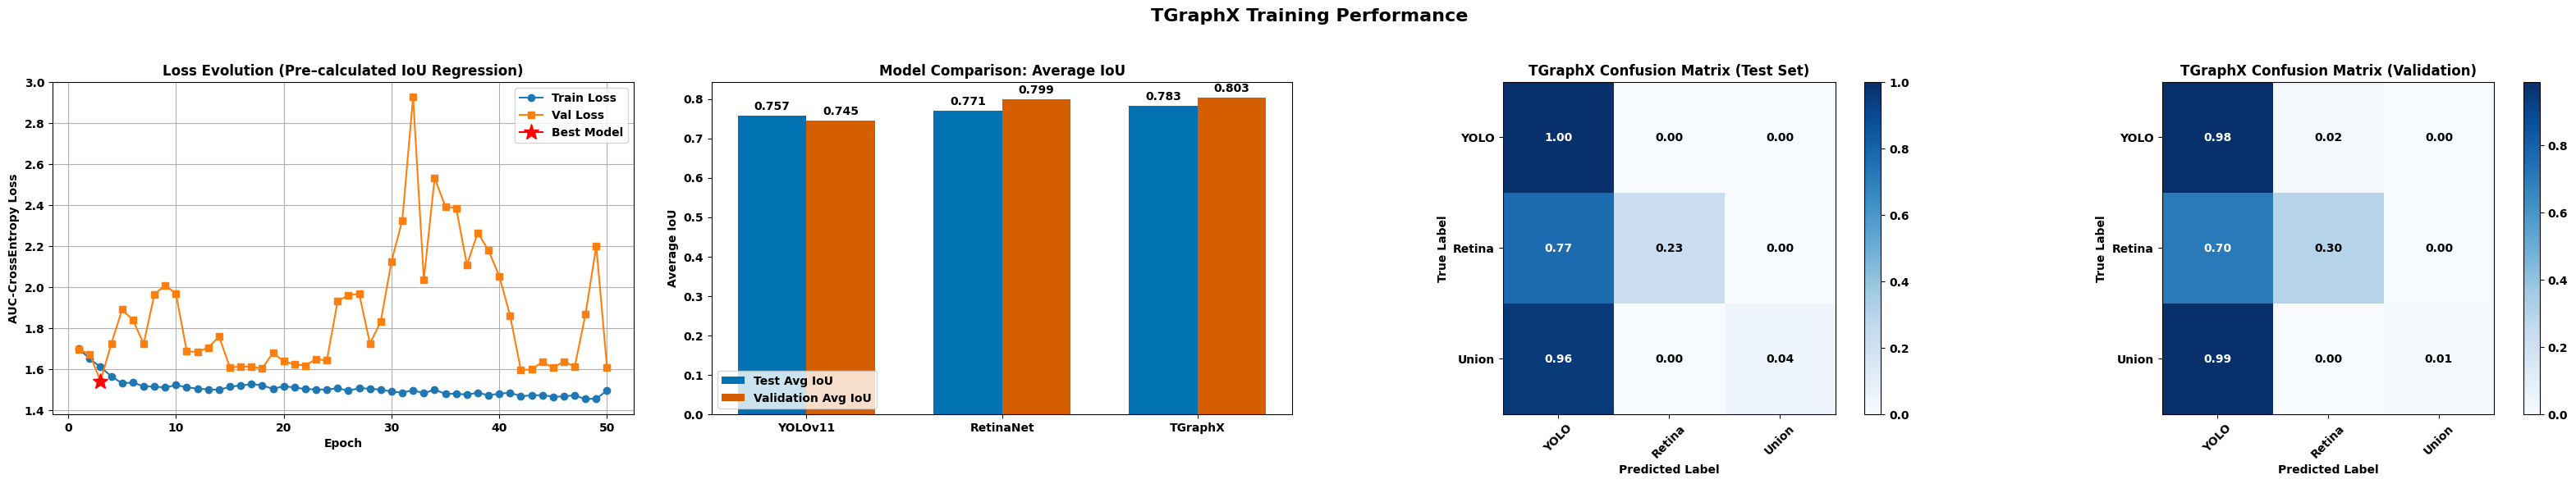

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Create a figure with 4 subplots in one row.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(32, 6))
fig.suptitle("TGraphX Training Performance", fontsize=16)

# -----------------------------
# Plot 1: Loss Evolution
# -----------------------------
if len(train_history) == 0 or len(val_history) == 0:
    ax1.text(0.5, 0.5, "Train/Val history not available.",
             horizontalalignment='center', verticalalignment='center')
else:
    # Unpack training and validation histories.
    epochs_train = [ep for (ep, loss) in train_history]
    losses_train = [loss for (ep, loss) in train_history]
    epochs_val   = [ep for (ep, loss) in val_history]
    losses_val   = [loss for (ep, loss) in val_history]

    # Identify the best epoch from validation history.
    if best_epoch in epochs_val:
        best_idx = epochs_val.index(best_epoch)
    else:
        best_idx = np.argmin(losses_val)
        best_epoch = epochs_val[best_idx]

    ax1.plot(epochs_train, losses_train, label="Train Loss", marker='o')
    ax1.plot(epochs_val, losses_val, label="Val Loss", marker='s')
    # Mark the best epoch.
    ax1.plot(best_epoch, losses_val[best_idx], marker='*', color='red', markersize=14, label='Best Model')
    ax1.set_title("Loss Evolution (Pre–calculated IoU Regression)")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("AUC-CrossEntropy Loss")
    ax1.legend()
    ax1.grid(True)

# -----------------------------
# Plot 2: Model Comparison Bar Plot (Test and Validation Sets)
# -----------------------------
# We assume final_test_comparison_data has columns "Model" and "Test Avg IoU",
# and final_val_comparison_data has columns "Model" and "Val Avg IoU".
models = final_test_comparison_data["Model"].tolist()
test_avg_ious = final_test_comparison_data["Test Avg IoU"].tolist()
val_avg_ious  = final_val_comparison_data["Val Avg IoU"].tolist()

x = np.arange(len(models))
width = 0.35

# Using colorblind-friendly colors:
color_test = "#0072B2"    # Blue for test
color_val  = "#D55E00"    # Orange for validation

rects_test = ax2.bar(x - width/2, test_avg_ious, width, label='Test Avg IoU', color=color_test)
rects_val  = ax2.bar(x + width/2, val_avg_ious, width, label='Validation Avg IoU', color=color_val)

ax2.set_ylabel("Average IoU")
ax2.set_title("Model Comparison: Average IoU")
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()

def autolabel(rects, axis):
    for rect in rects:
        height = rect.get_height()
        axis.annotate(f'{height:.3f}',
                      xy=(rect.get_x() + rect.get_width()/2, height),
                      xytext=(0, 3),
                      textcoords="offset points",
                      ha='center', va='bottom')

autolabel(rects_test, ax2)
autolabel(rects_val, ax2)

# -----------------------------
# Plot 3: Confusion Matrix (Normalized) for Test Set
# -----------------------------
# We assume that cm_test_norm is defined and is a NumPy array of shape (3, 3).
cm_norm_array = cm_test_norm
classes = ["YOLO", "Retina", "Union"]

im = ax3.imshow(cm_norm_array, interpolation='nearest', cmap=plt.cm.Blues)
ax3.set_title("TGraphX Confusion Matrix (Test Set)")
fig.colorbar(im, ax=ax3)
tick_marks = np.arange(len(classes))
ax3.set_xticks(tick_marks)
ax3.set_xticklabels(classes, rotation=45)
ax3.set_yticks(tick_marks)
ax3.set_yticklabels(classes)
fmt = '.2f'
thresh = cm_norm_array.max() / 2.
for i, j in itertools.product(range(cm_norm_array.shape[0]), range(cm_norm_array.shape[1])):
    ax3.text(j, i, format(cm_norm_array[i, j], fmt),
             ha="center", va="center",
             color="white" if cm_norm_array[i, j] > thresh else "black")
ax3.set_ylabel('True Label')
ax3.set_xlabel('Predicted Label')

# -----------------------------
# Plot 4: Confusion Matrix (Normalized) for Validation Set
# -----------------------------
# Reinitialize necessary variables.
classes = ["YOLO", "Retina", "Union"]
tick_marks = np.arange(len(classes))
fmt = '.2f'

# Use the normalized confusion matrix for validation.
cm_val_array = cm_val_norm  # cm_val_norm should be defined earlier.
im_val = ax4.imshow(cm_val_array, interpolation='nearest', cmap=plt.cm.Blues)
ax4.set_title("TGraphX Confusion Matrix (Validation)")
fig.colorbar(im_val, ax=ax4)
ax4.set_xticks(tick_marks)
ax4.set_xticklabels(classes, rotation=45)
ax4.set_yticks(tick_marks)
ax4.set_yticklabels(classes)
thresh_val = cm_val_array.max() / 2.
for i, j in itertools.product(range(cm_val_array.shape[0]), range(cm_val_array.shape[1])):
    ax4.text(j, i, format(cm_val_array[i, j], fmt),
             ha="center", va="center",
             color="white" if cm_val_array[i, j] > thresh_val else "black")
ax4.set_ylabel('True Label')
ax4.set_xlabel('Predicted Label')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Save high-quality versions of the plot
fig.savefig("tgraphx_training_performance.png", dpi=300, bbox_inches='tight')
fig.savefig("tgraphx_training_performance.svg", format='svg', bbox_inches='tight')

# Show the plot
plt.show()

